# Решение #1 - Фильтрация

### Импортирование библиотек и загрузка датасета

In [2]:
from src import *
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from tqdm.auto import tqdm
from ipywidgets import FloatProgress

import warnings
warnings.filterwarnings("ignore")

df = pd.read_json('./../data/sample.json')

### Предобработка строк

In [3]:
df['text_preprocess'] = df['text'].apply(load_dataset.preprocess_text)
strings = list(df['text_preprocess'])

In [152]:
strings

['ты нашел их или нет',
 'почему она так со мной поступает',
 'никто туда больше не ходит',
 'у него с собой не было тогда денег',
 'почему они с нами так поступают',
 'он всю ночь стонал от сильной боли',
 'я больше не хочу с тобой играть',
 'тому было тогда всего тринадцать лет',
 'что сделал том с деньгами',
 'том меня сейчас хочет видеть',
 'он даже меня не замечает',
 'тебе это все нравится',
 'у него тогда не было с собой денег',
 'я его больше не увижу',
 'почему она так с ней поступает',
 'я хотел бы учиться в бостоне',
 'том и мэри объявили сегодня о своей пбмолвке',
 'том этим сейчас занимается',
 'я не могу больше ждать',
 'мост очень длинный и высокий',
 'том был просто не готов',
 'пусть свиньи это едят',
 'я ничего не хочу делать',
 'ты хотел мне рассказать о свободе',
 'что пел джон на сцене',
 'я написал влера письмо',
 'тому это тоже не нравится',
 'сколько сейчас времени в париже',
 'мы не были готовы',
 'они их только что нашли',
 'тому было больше не к кому обратить

### Структура датасета

In [153]:
df.head()

,id,text,text_preprocess
0,1,Ты нашёл их или нет?,ты нашел их или нет
1,2,Почему она так со мной поступает?,почему она так со мной поступает
2,3,Никто туда больше не ходит.,никто туда больше не ходит
3,4,У него с собой не было тогда денег.,у него с собой не было тогда денег
4,5,Почему они с нами так поступают?,почему они с нами так поступают


# 1 вариант

In [32]:
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.decomposition import PCA
from sklearn.cluster import DBSCAN
import math
from typing import List

# np.seterr(divide='ignore', invalid='ignore') # игнорирование предупреждений

def make_cluster(strings:List[str]):
    if len(set(strings)) == 1:
        return [strings]
    # Векторизация
    Vectorizer = CountVectorizer()
    vector = Vectorizer.fit_transform(strings)
    strings_vectorized = vector.toarray()

    # Уменьшение размерности
    pca_model = PCA(n_components=2).fit(strings_vectorized)
    strings_vectorized_2n = pca_model.transform(strings_vectorized)

    # Кластеризация
    diff_x = max(strings_vectorized_2n[:,0]) - min(strings_vectorized_2n[:,0])
    diff_y = max(strings_vectorized_2n[:,1]) - min(strings_vectorized_2n[:,1])

    eps = (diff_x * diff_y)**0.6 / math.log(len(strings),2)
    if eps == 0.0:
        return [strings]
    # print('eps = ',eps)
    model = DBSCAN(eps=eps,min_samples=1).fit(strings_vectorized_2n)
    clusters = {}
    for i in range(len(model.labels_)):
        if model.labels_[i] not in clusters:
            clusters[model.labels_[i]] = []
        clusters[model.labels_[i]].append(strings[i])

    # plt.scatter(strings_vectorized_2n[:,0],strings_vectorized_2n[:,1],c=model.labels_)
    return list(clusters.values())

In [36]:
clusters = make_cluster(strings)
for iter in range(4):
    for i,cluster in enumerate(clusters):
        clusters[i] = make_cluster(cluster);
    clusters = [item for cluster in clusters for item in cluster];

In [39]:
[sorted(cluster) for cluster in clusters]

[['ты нашел их или нет',
  'он всю ночь стонал от сильной боли',
  'тому было тогда всего тринадцать лет',
  'я написал влера письмо',
  'сколько сейчас времени в париже',
  'я живу сейчас в бостоне',
  'они три года провели в тюрьме',
  'я поймал сегодня три рыбы',
  'тому было нечего сказать',
  'я тоже завтра пойду в университет',
  'я рмогу там быть через час',
  'я тебя видел с высоким парнем',
  'я видел тебя с высоким парнем',
  'я редко видел его в школе',
  'я думаю вса время о томе',
  'мы много времени провгдим вместе',
  'я здесь часто ем',
  'какая гора самая высокая в мире',
  'я покажу вам несколько фотографий',
  'здесь есть поблизости банкомат',
  'у меня нет дома компьютера',
  'мы теряем здесь время',
  'можешь меня высадить у библиотеки',
  'я его редко видел в школе',
  'лакая гора самая высокая в европе',
  'ты играешь в футбол или регби',
  'у меня дома нет компьютера',
  'зачем тому была нужна отвертка',
  'говорят в горах погода быстро меняется',
  'сколько теб

In [38]:
[len(cluster) for cluster in clusters]

[87,
 6,
 2,
 2,
 3,
 10,
 2,
 2,
 6,
 2,
 4,
 1,
 9,
 1,
 1,
 2,
 1,
 2,
 1,
 1,
 2,
 3,
 2,
 1,
 2,
 1,
 16,
 1,
 2,
 2,
 2,
 4,
 2,
 1,
 2,
 5,
 2,
 2,
 2,
 1,
 1,
 2,
 1,
 1,
 2,
 2,
 2,
 1,
 1,
 2,
 2,
 2,
 2,
 1,
 1,
 1,
 2,
 1,
 2,
 2,
 2,
 1,
 60,
 2,
 2,
 2,
 1,
 2,
 2,
 2,
 1,
 2,
 2,
 1,
 2,
 1,
 1,
 1,
 2,
 1,
 1,
 2,
 1,
 1,
 1,
 1,
 2,
 1,
 4,
 15,
 2,
 2,
 2,
 2,
 1,
 1,
 1,
 1,
 1,
 1,
 2,
 1,
 1,
 2,
 1,
 2,
 1,
 1,
 1,
 1,
 1,
 1,
 2,
 2,
 1,
 2,
 3,
 2,
 2,
 1,
 1,
 2,
 1,
 1,
 1,
 1,
 2,
 1,
 1,
 1,
 2,
 2,
 1,
 1]

# 2 Вариант

In [59]:
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
import math
from typing import List



def km(strings):
    if len(set(strings)) <= 2:
        return [strings]
        
    # Векторизация
    Vectorizer = CountVectorizer()
    vector = Vectorizer.fit_transform(strings)
    strings_vectorized = vector.toarray()

    # Уменьшение размерности
    pca_model = PCA(n_components=2).fit(strings_vectorized)
    strings_vectorized_2n = pca_model.transform(strings_vectorized)

    model = KMeans(n_clusters=2,n_init="auto").fit(strings_vectorized_2n)
    clusters = {}
    for i in range(len(model.labels_)):
        if model.labels_[i] not in clusters:
            clusters[model.labels_[i]] = []
        clusters[model.labels_[i]].append(strings[i])

    plt.scatter(strings_vectorized_2n[:,0],strings_vectorized_2n[:,1],c=model.labels_)
    plt.show()
    return list(clusters.values())

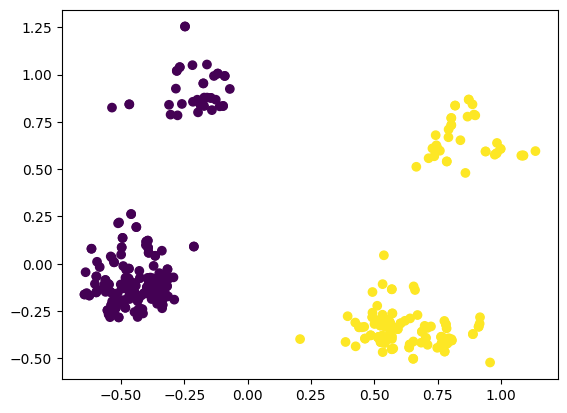

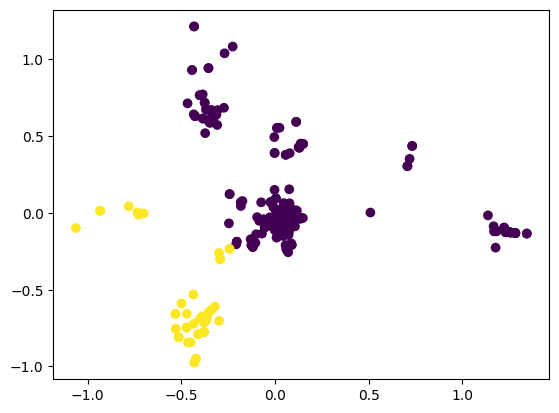

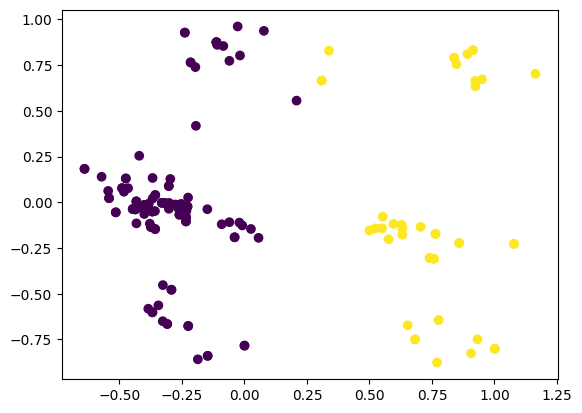

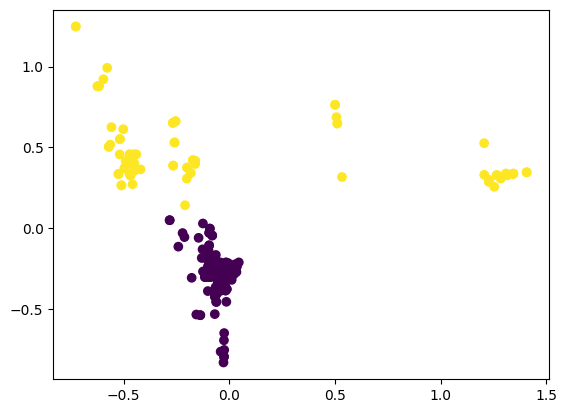

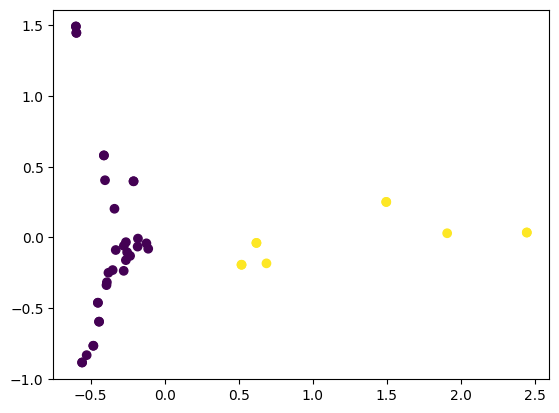

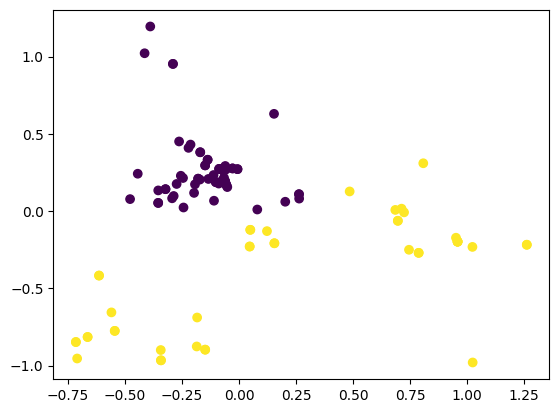

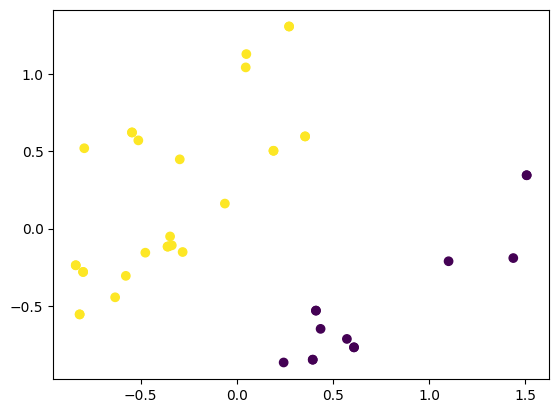

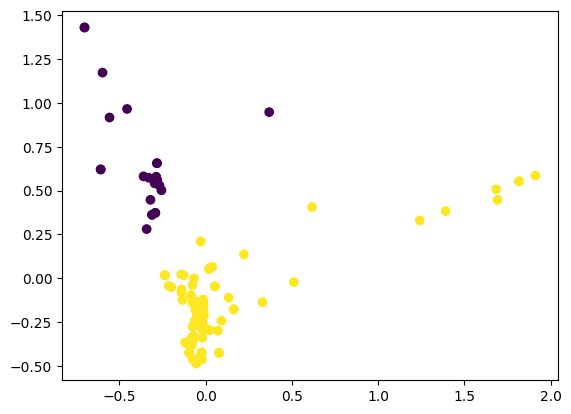

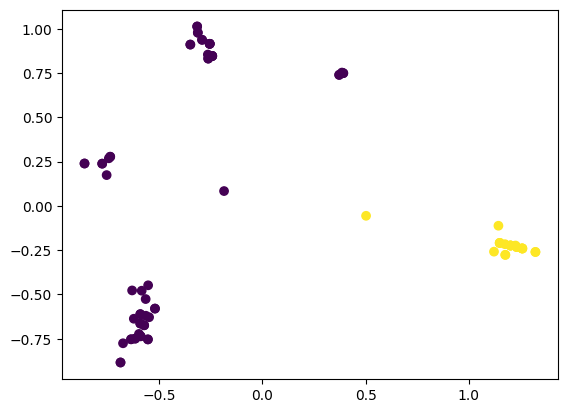

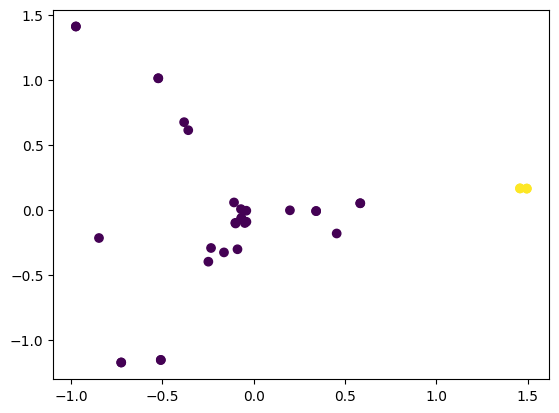

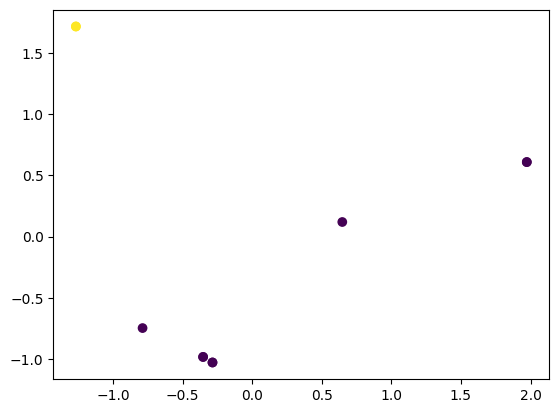

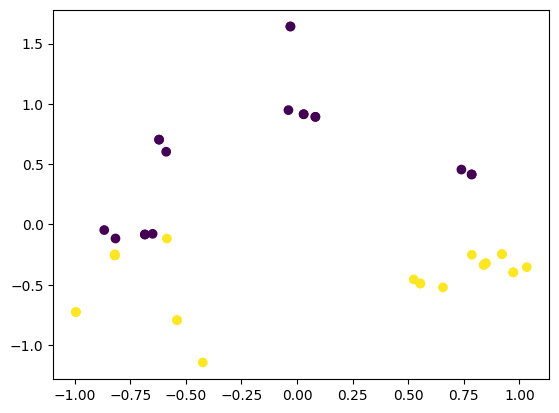

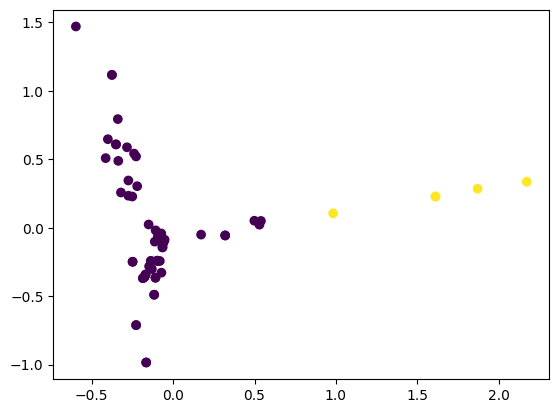

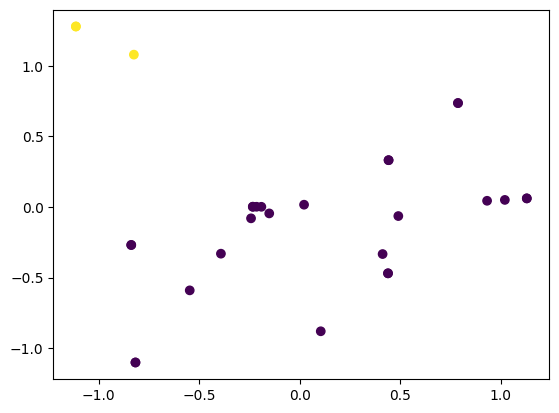

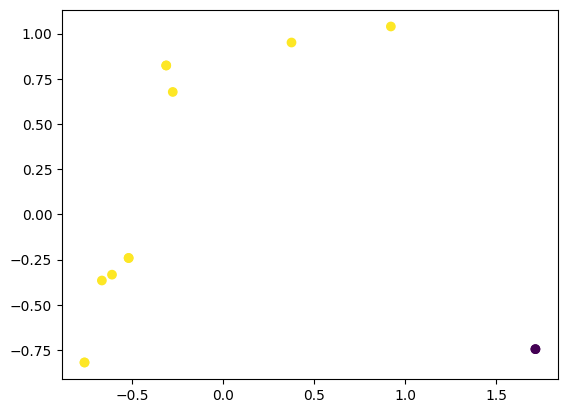

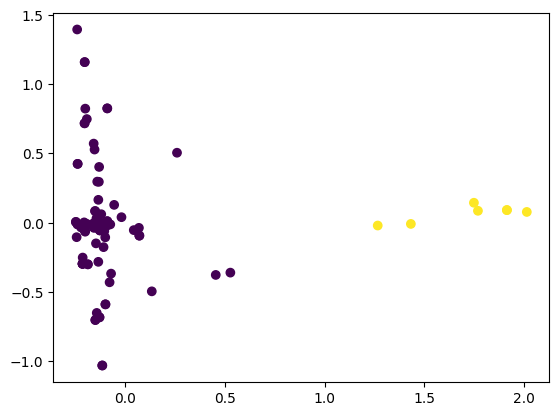

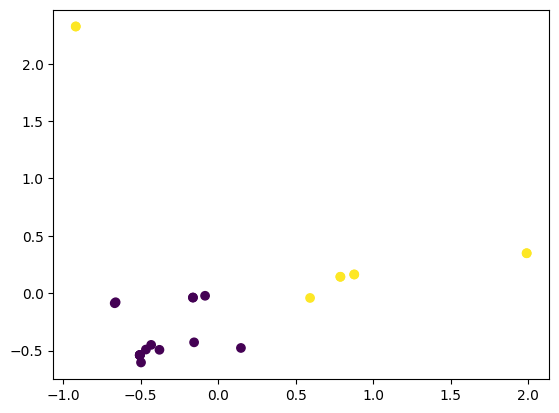

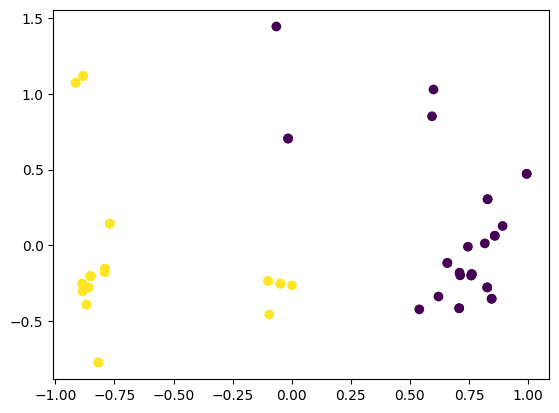

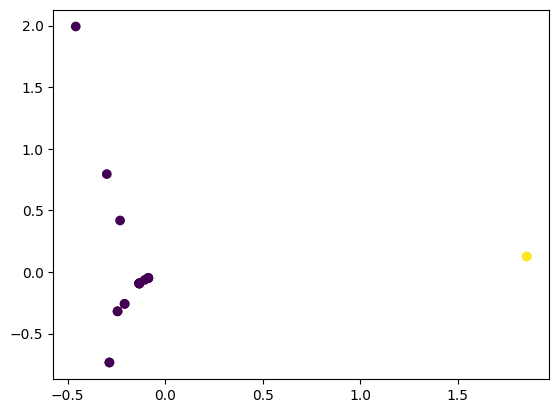

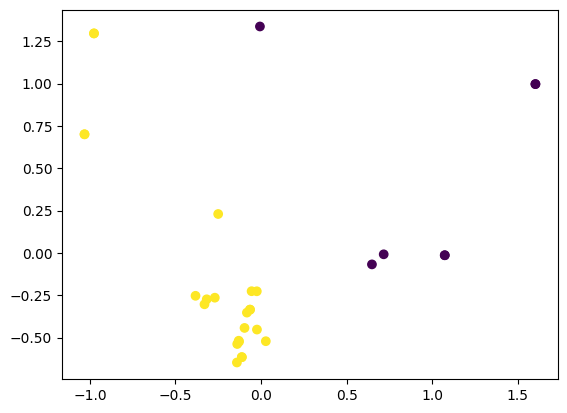

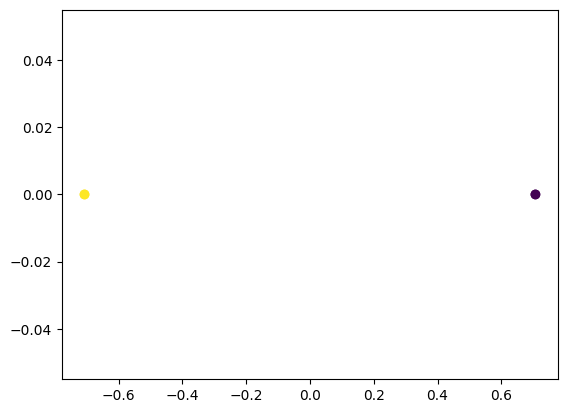

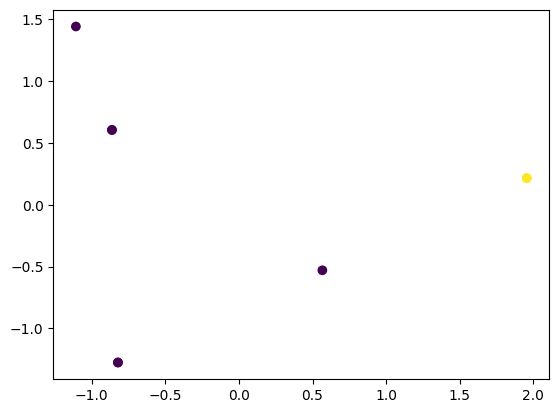

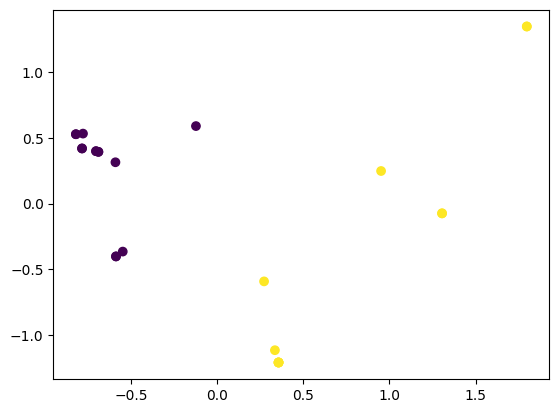

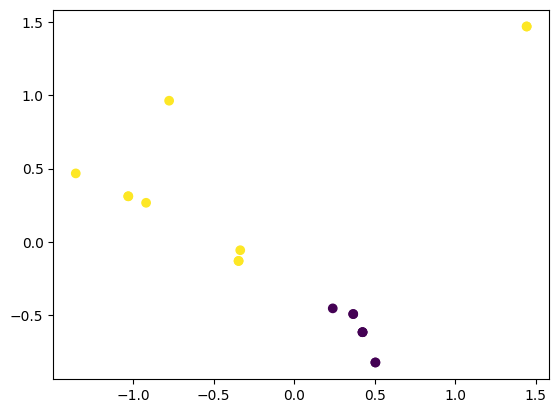

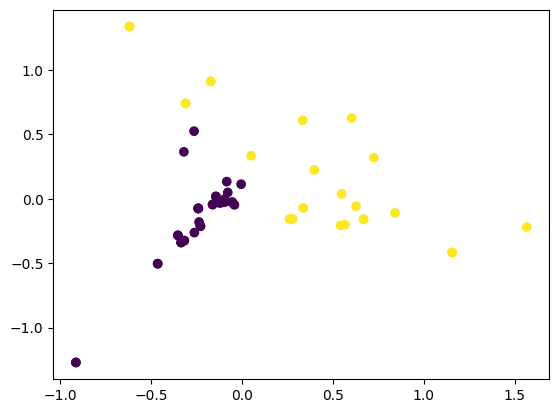

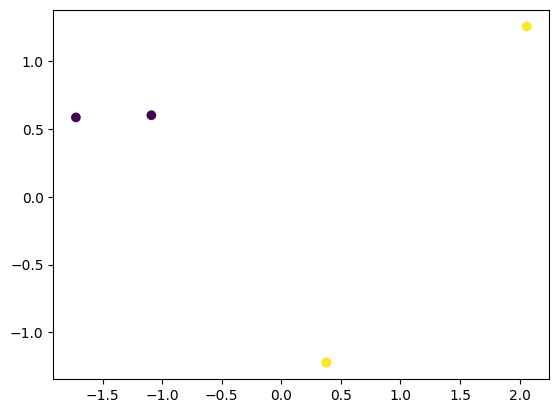

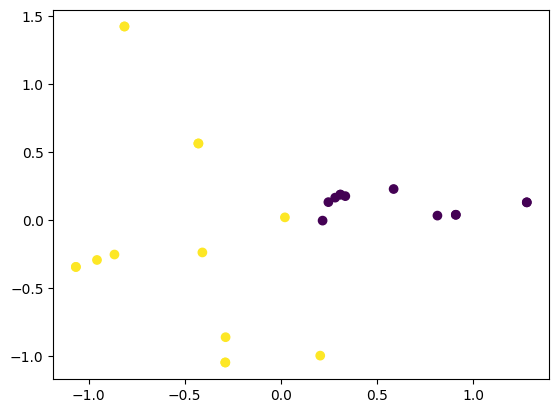

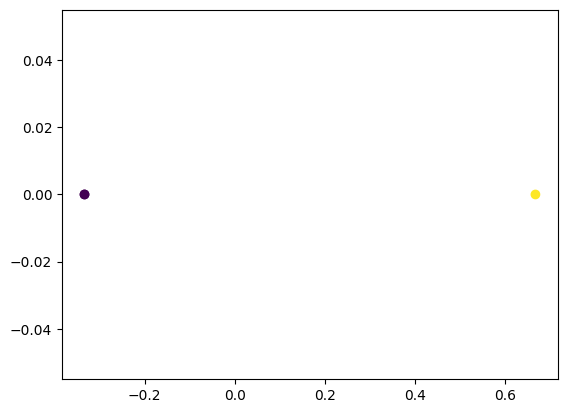

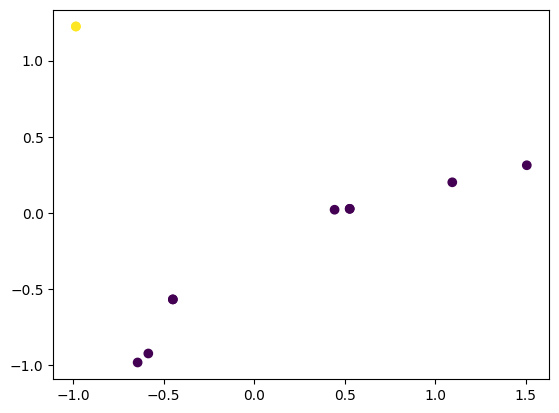

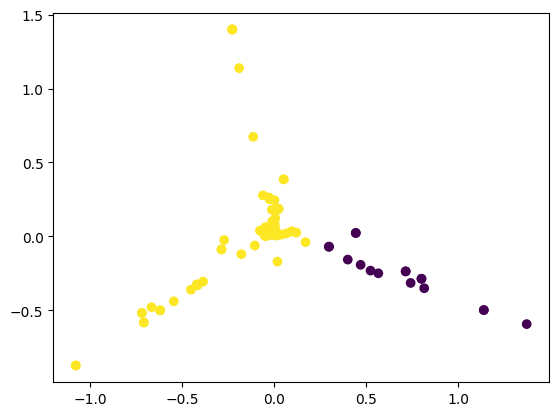

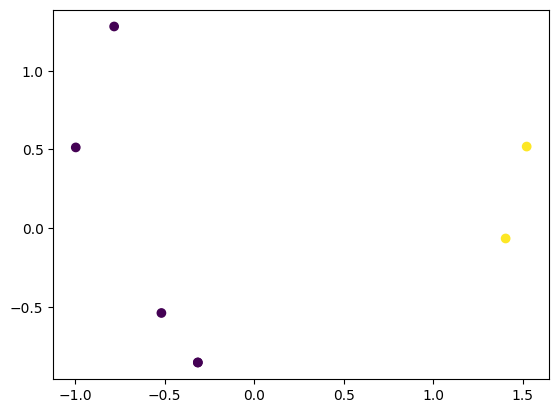

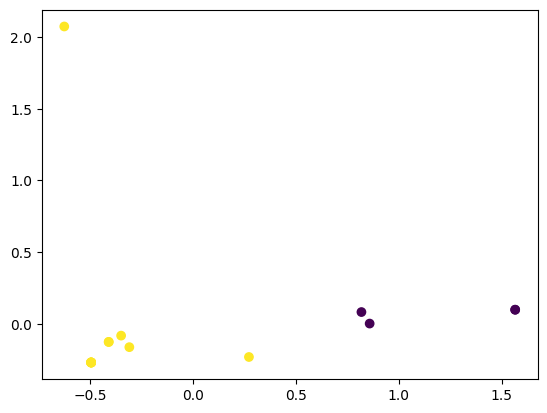

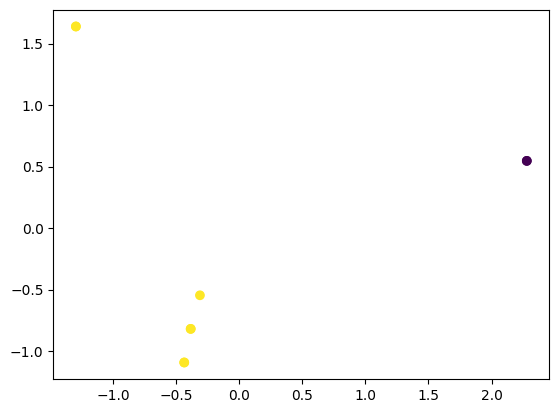

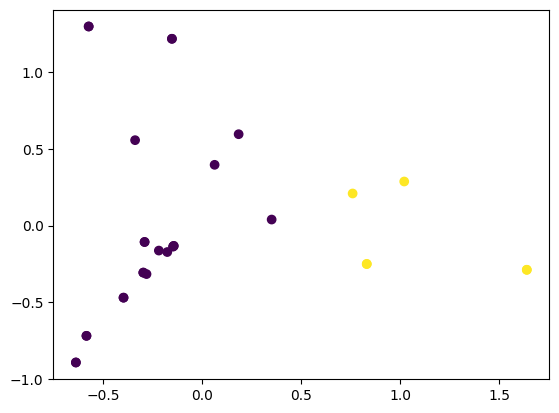

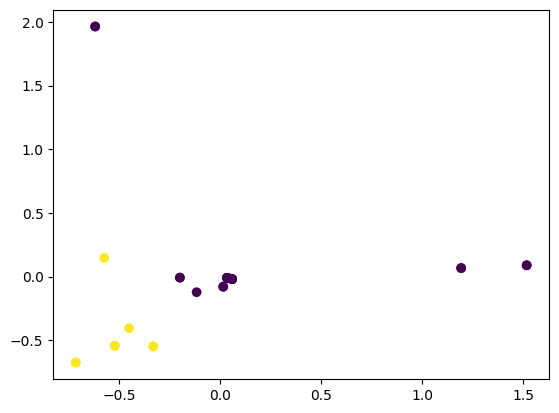

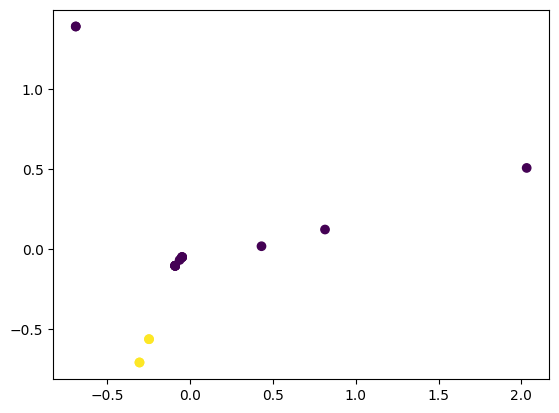

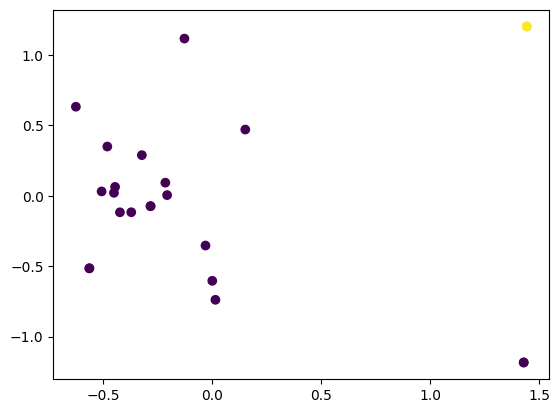

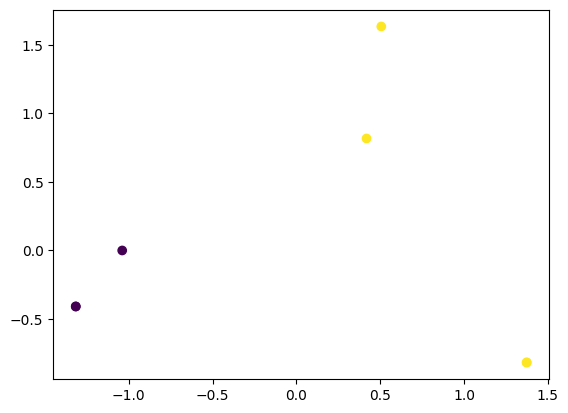

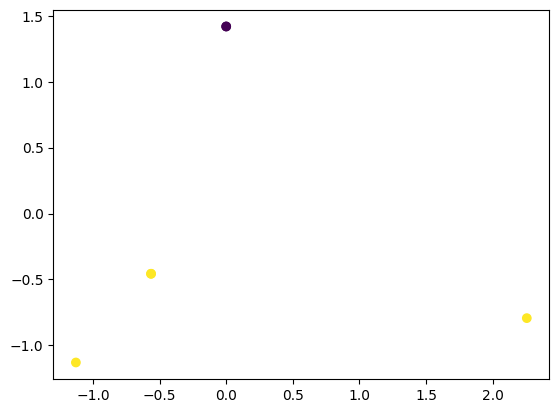

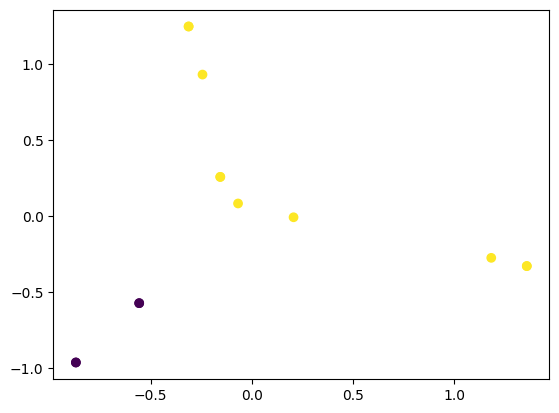

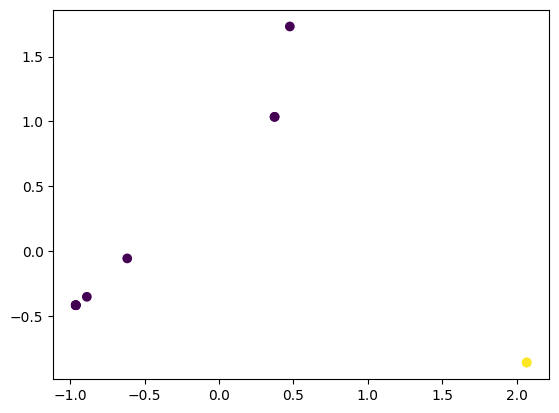

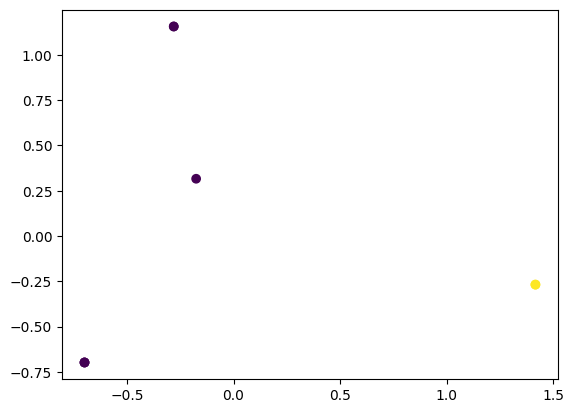

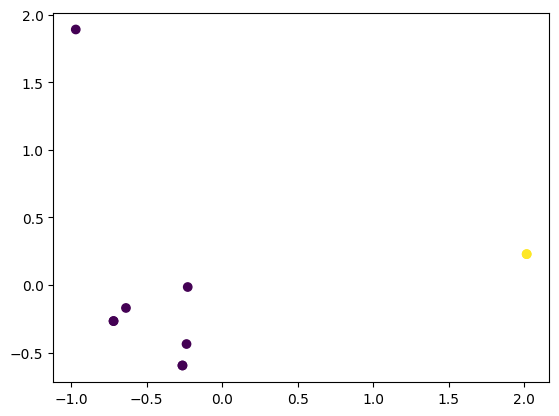

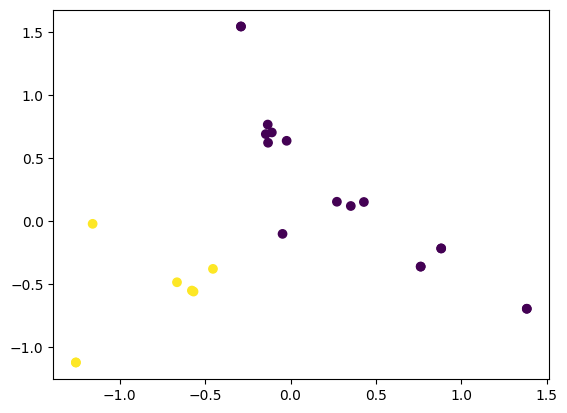

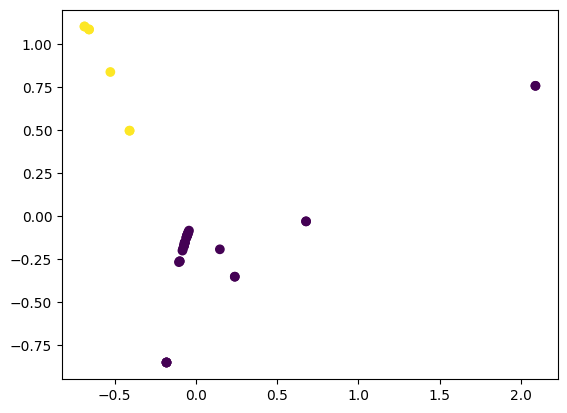

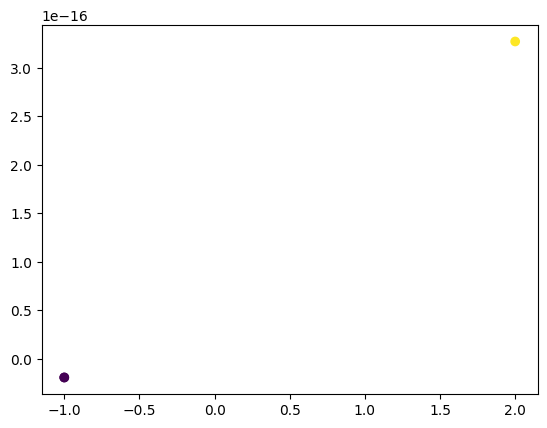

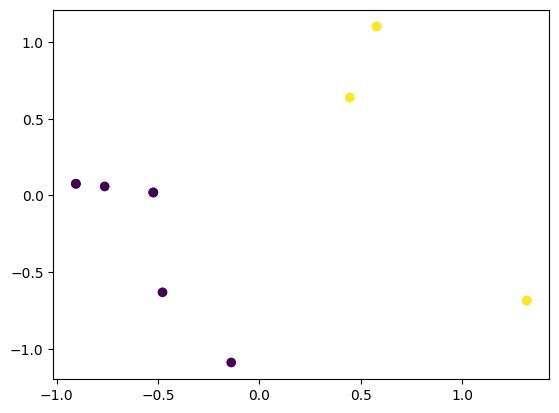

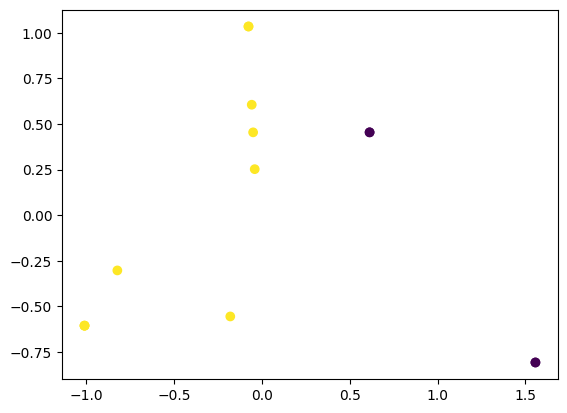

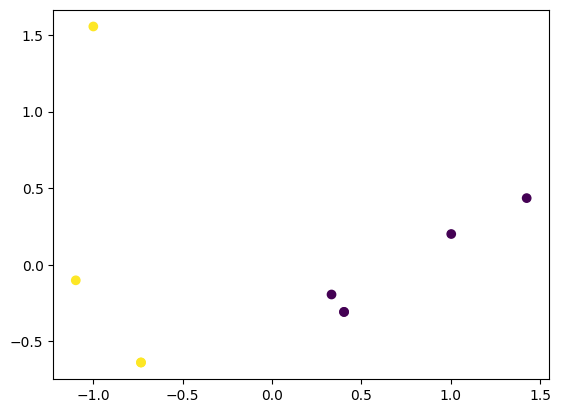

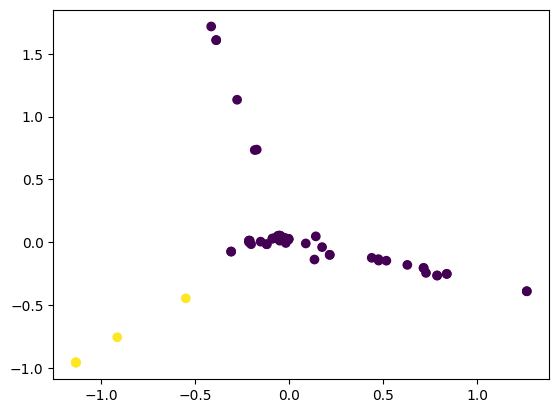

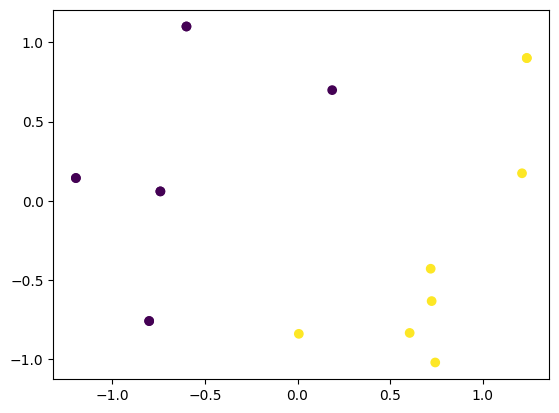

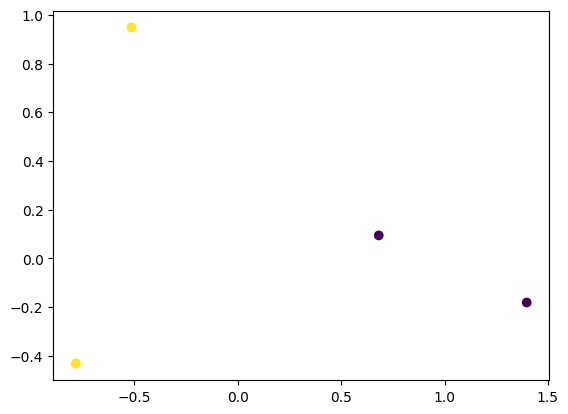

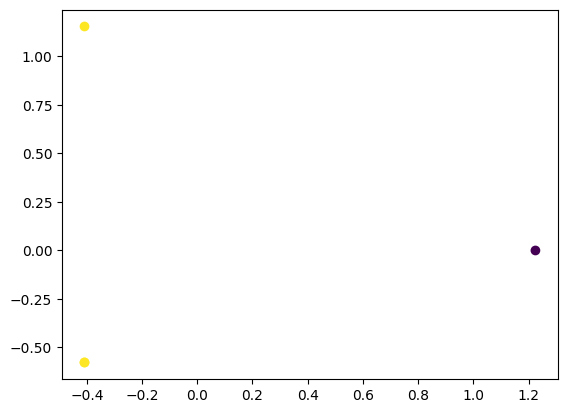

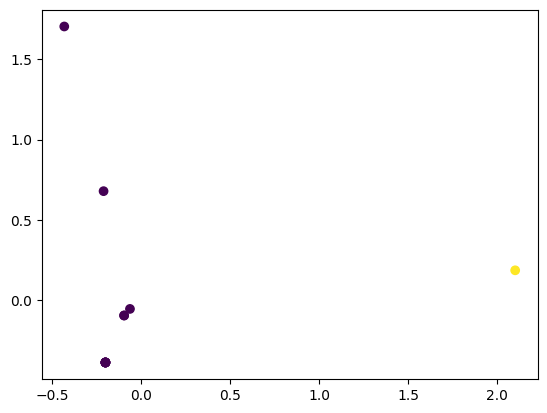

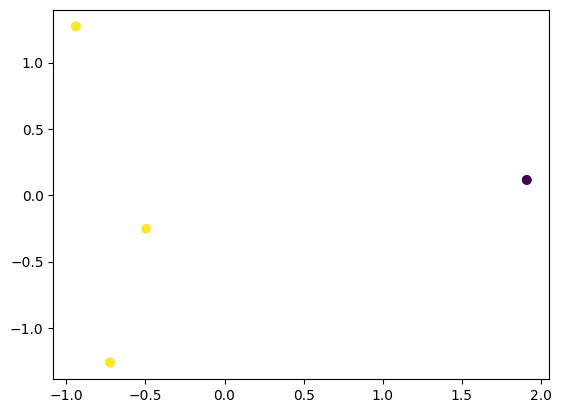

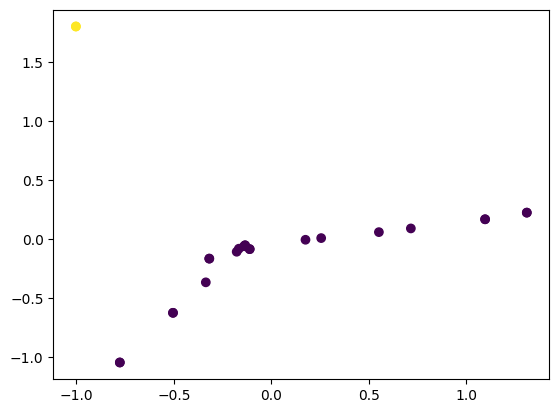

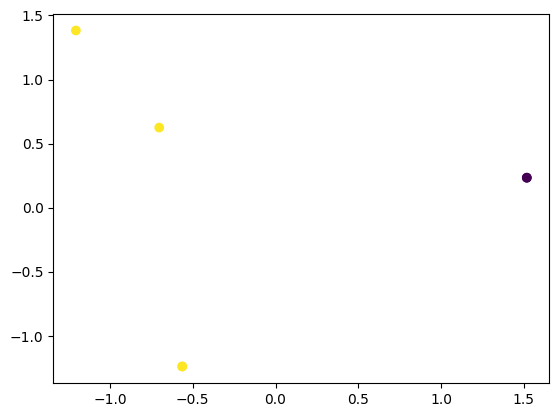

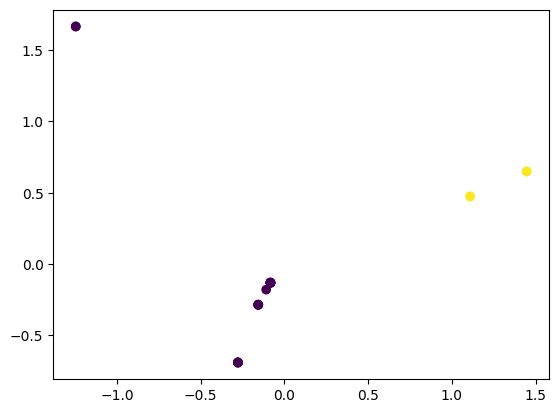

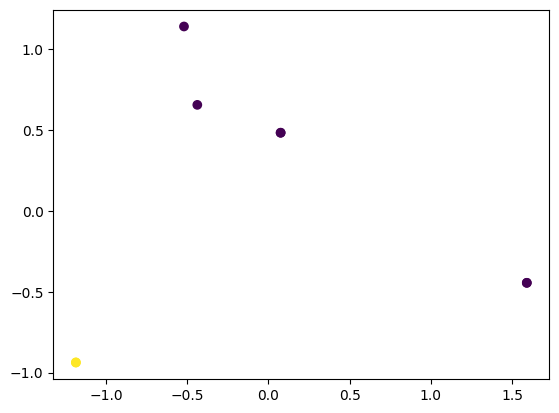

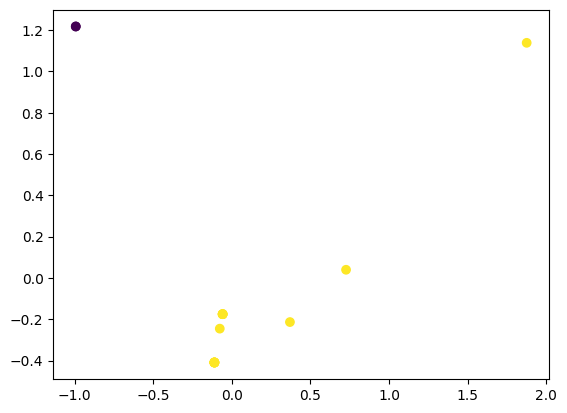

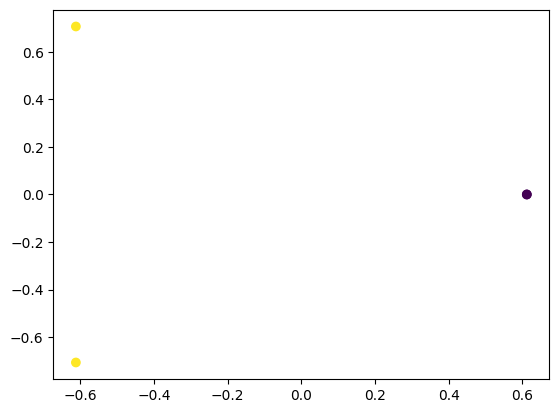

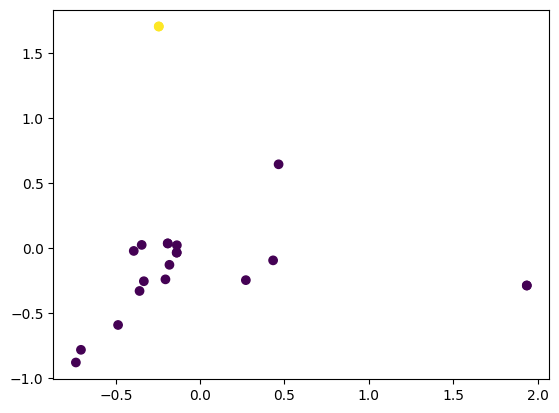

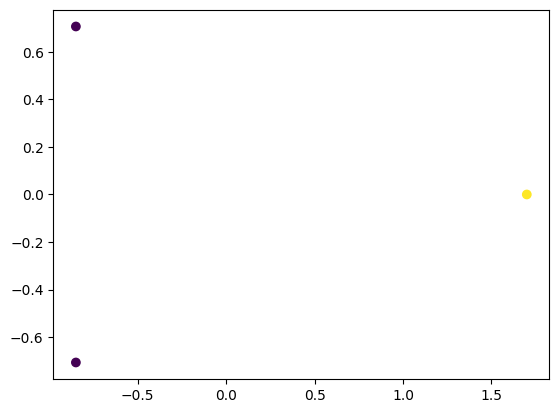

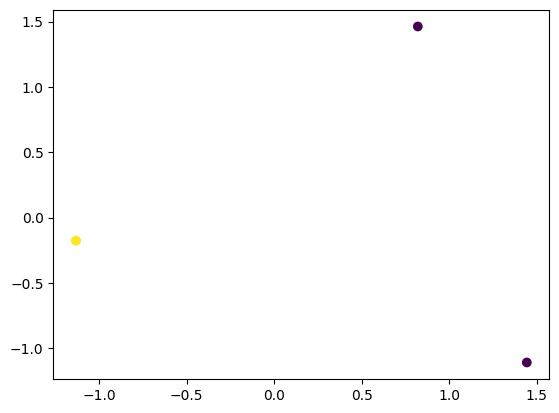

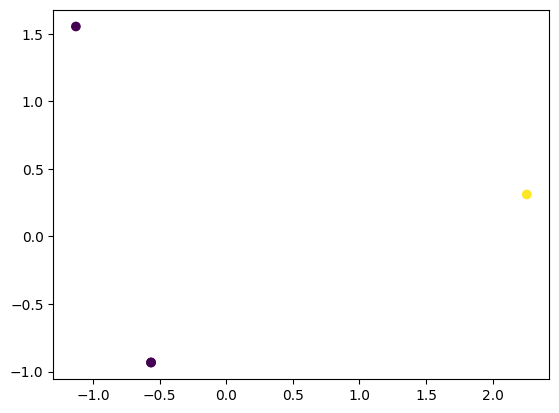

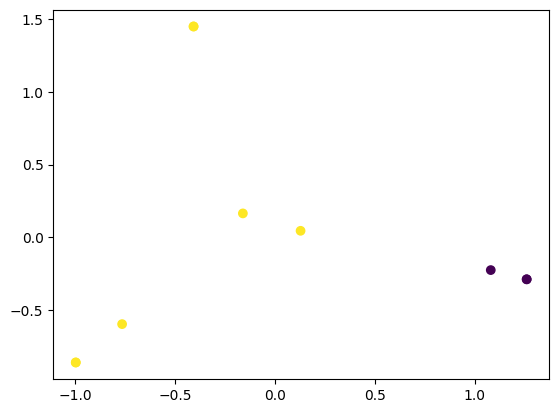

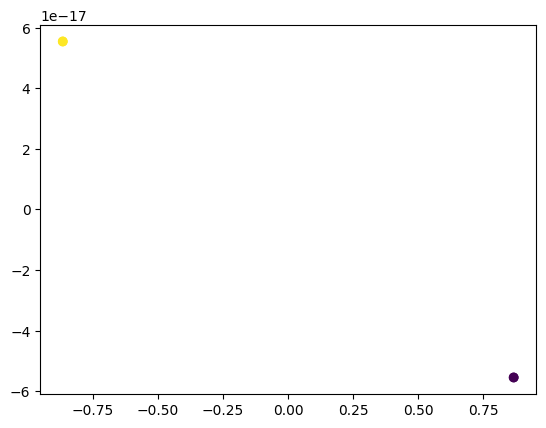

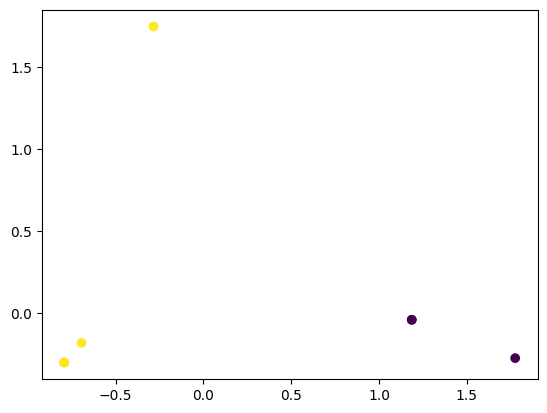

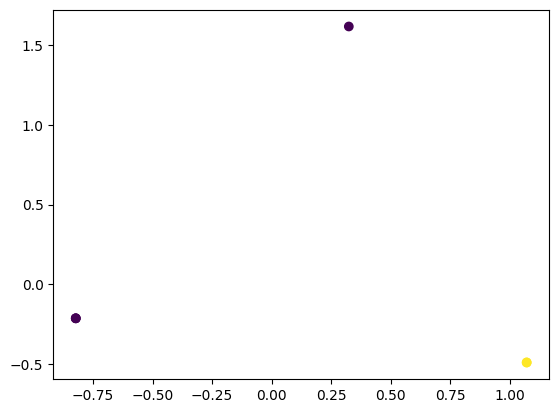

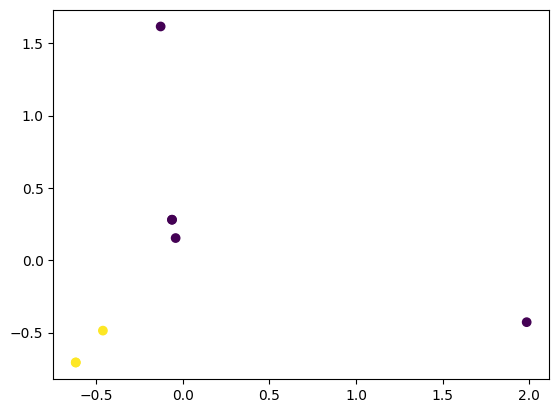

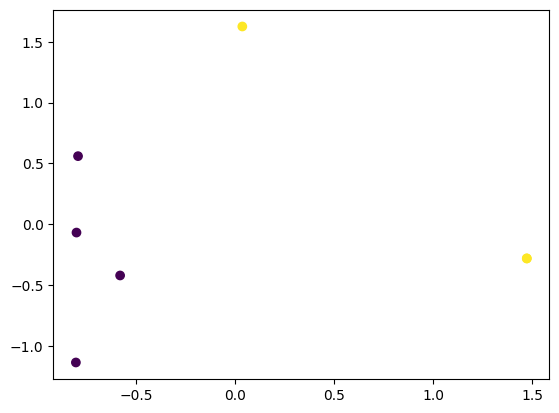

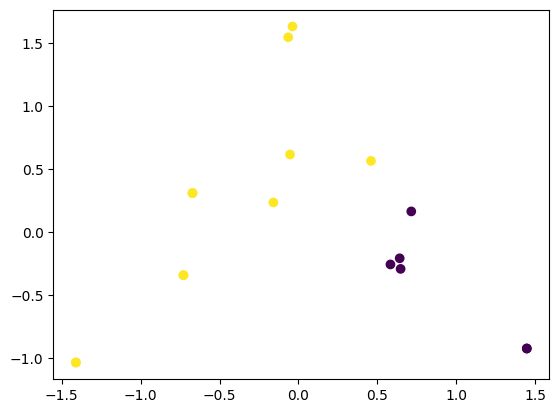

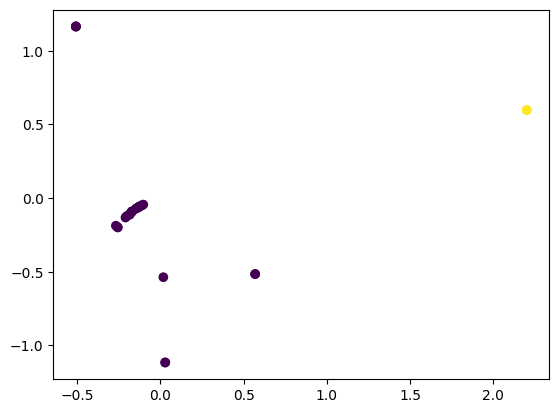

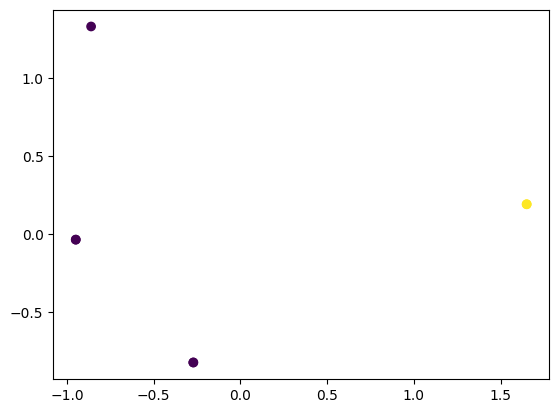

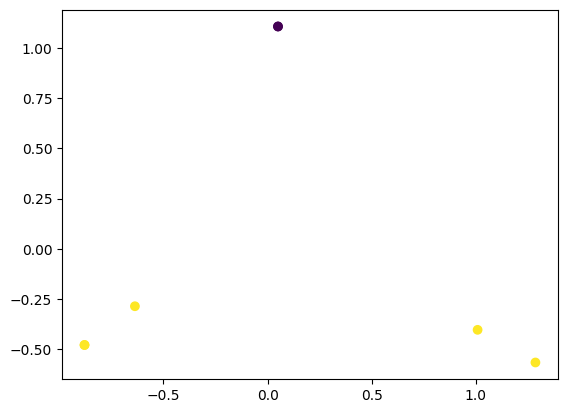

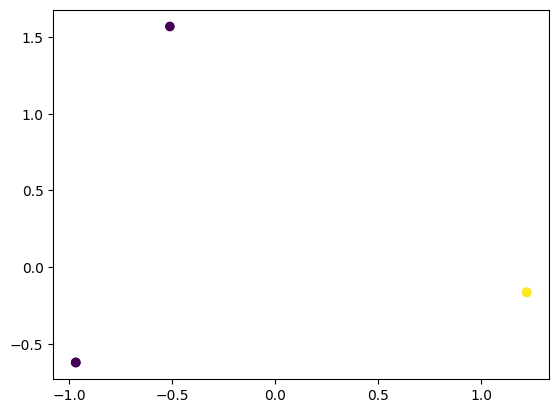

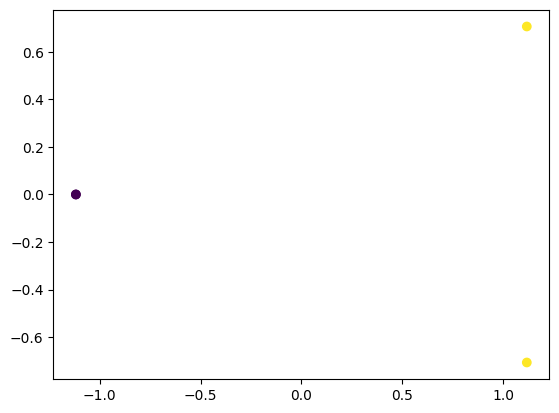

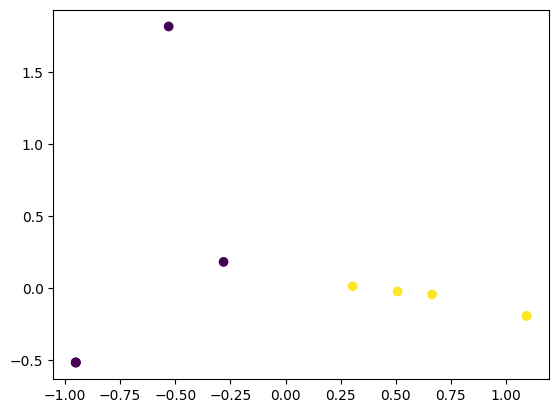

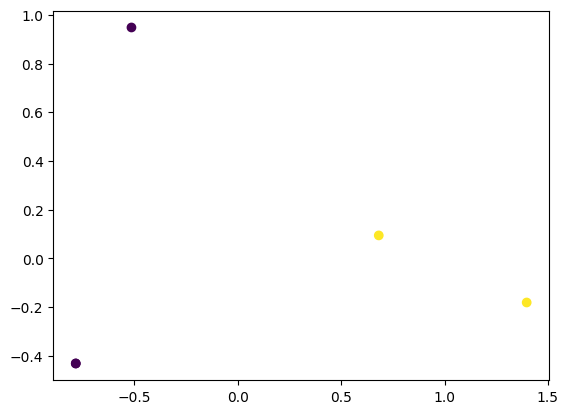

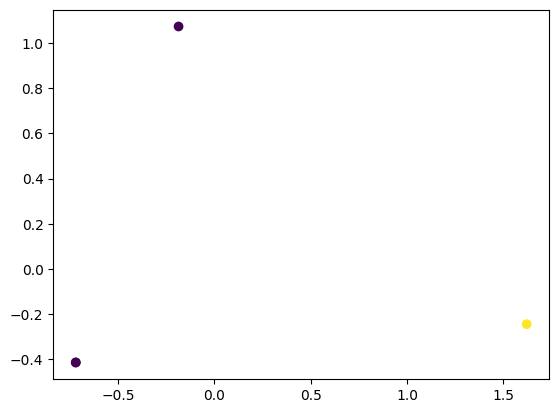

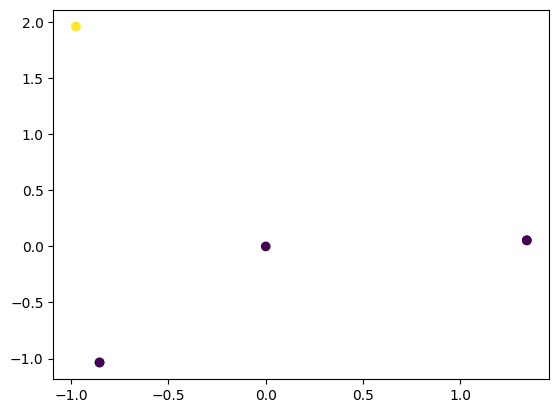

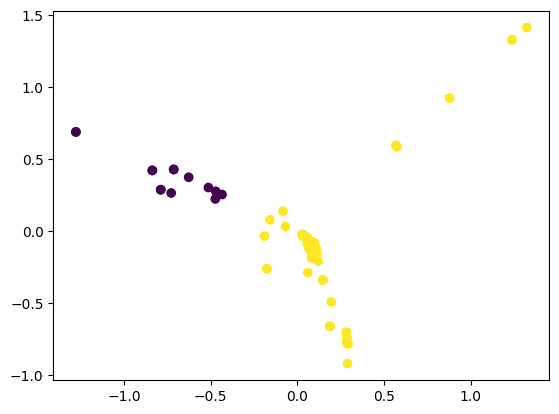

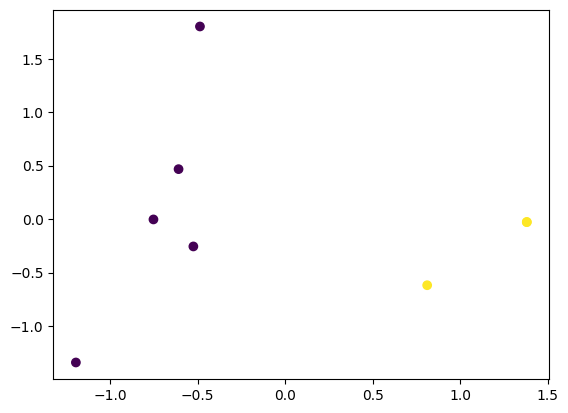

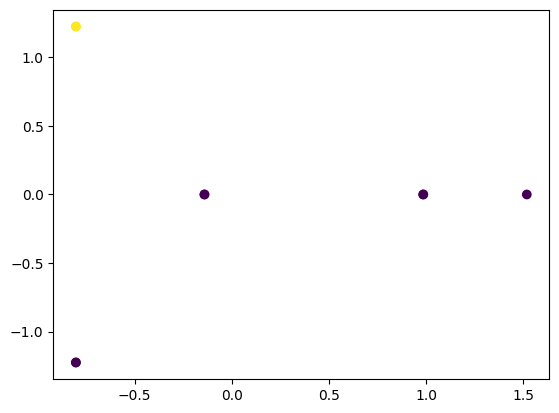

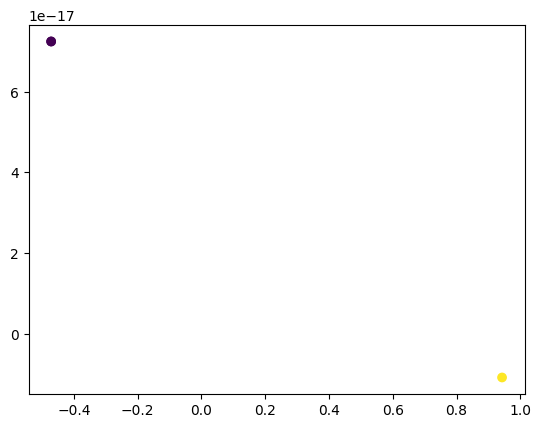

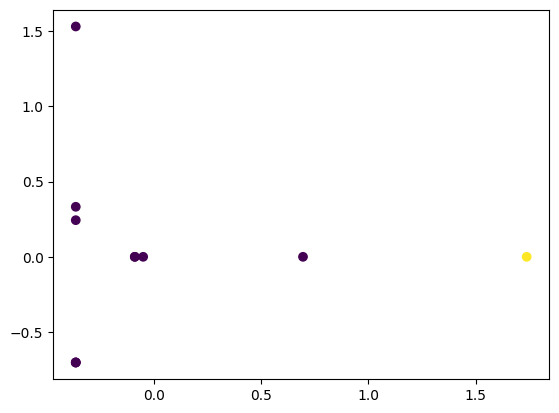

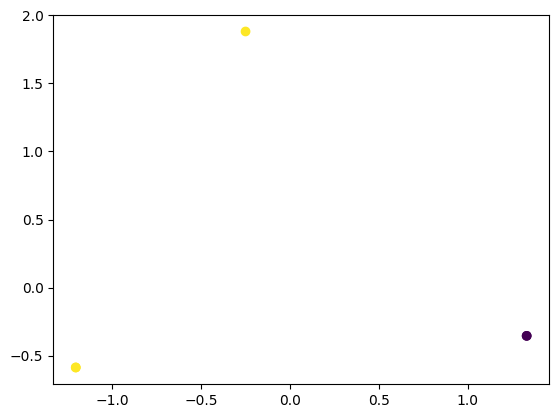

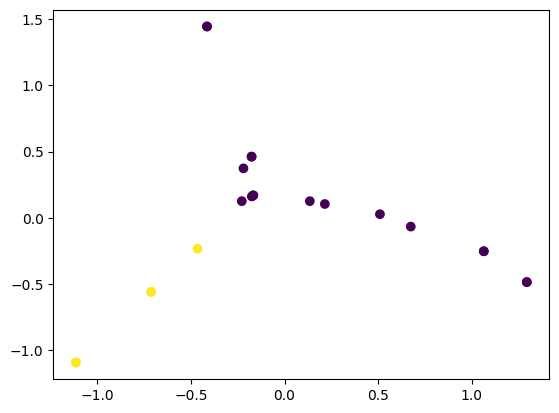

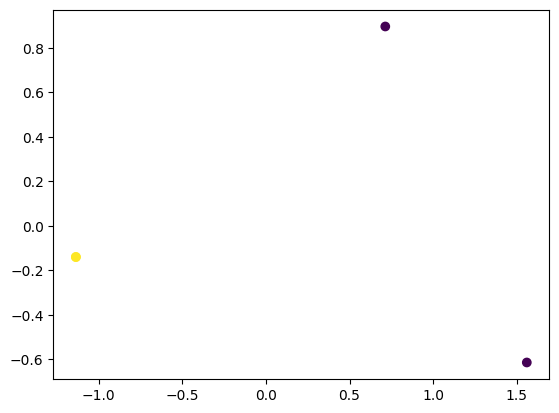

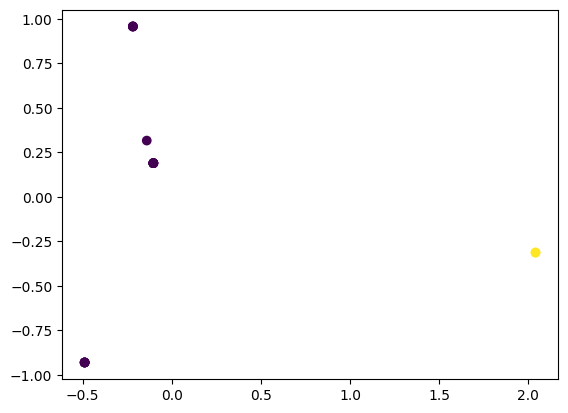

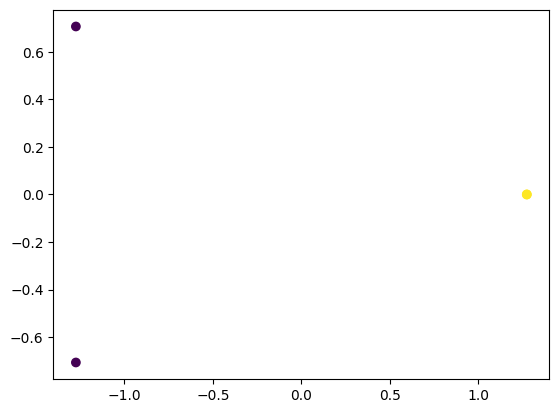

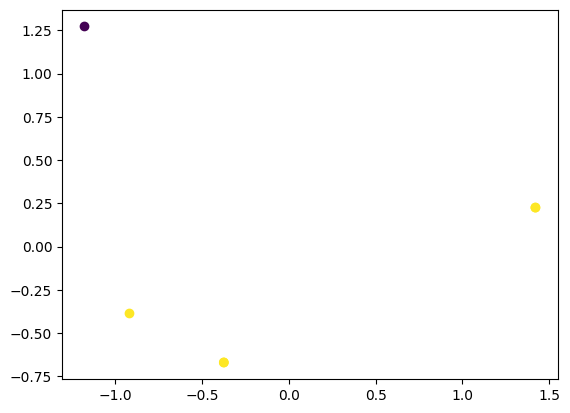

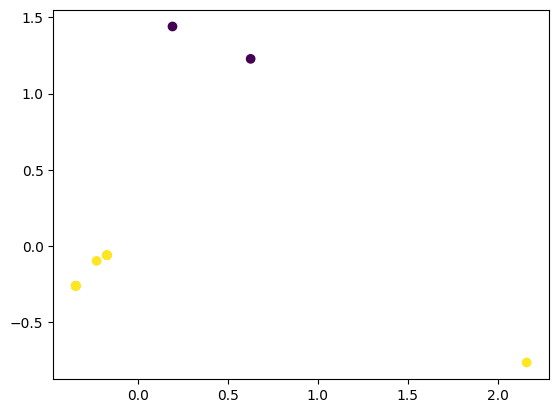

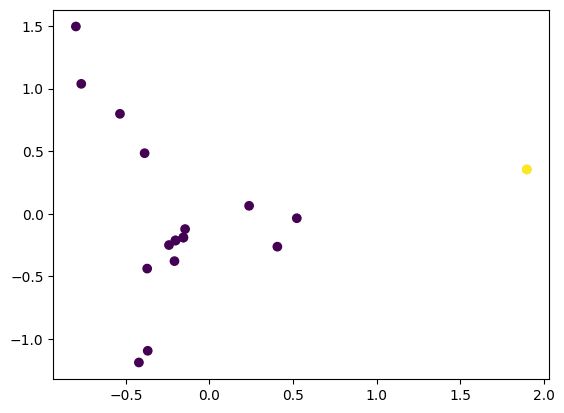

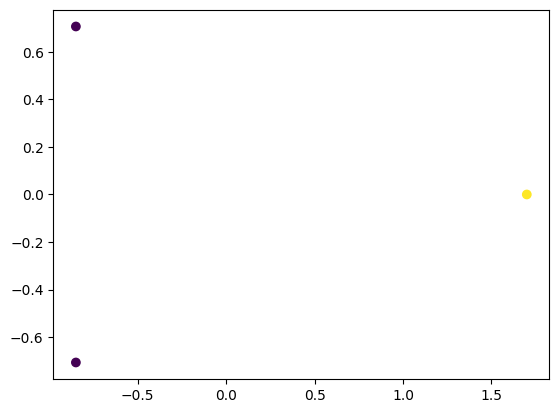

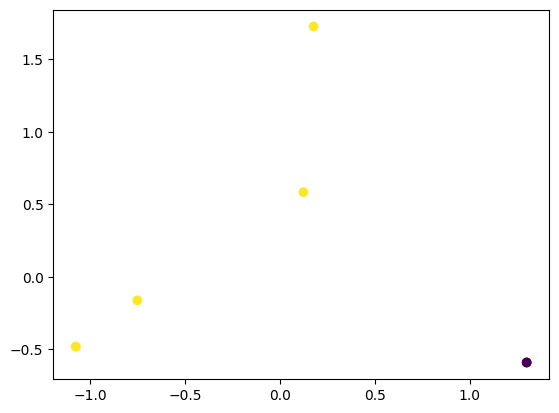

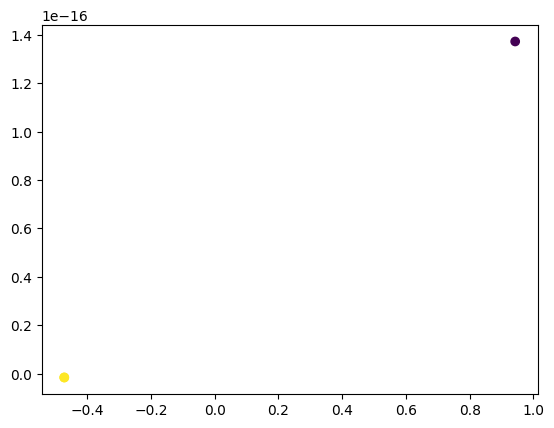

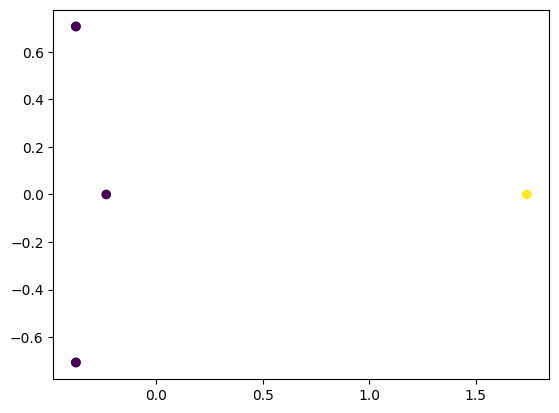

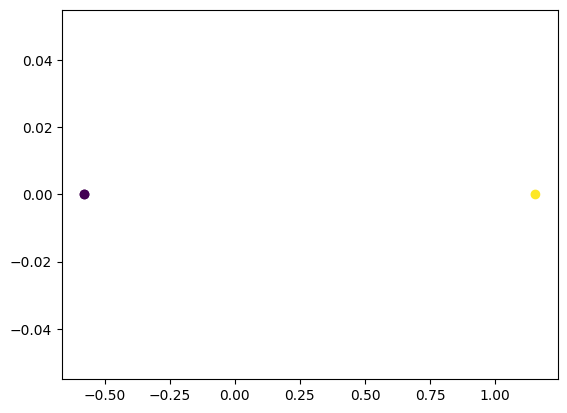

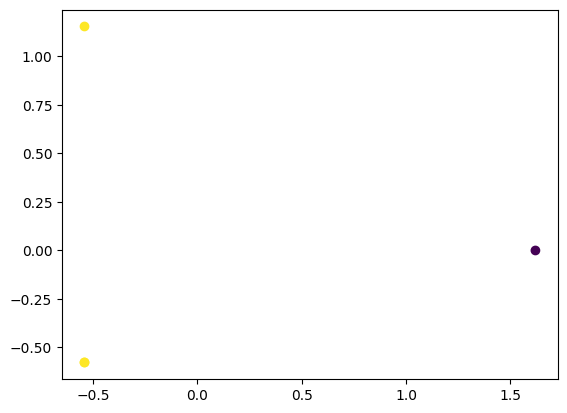

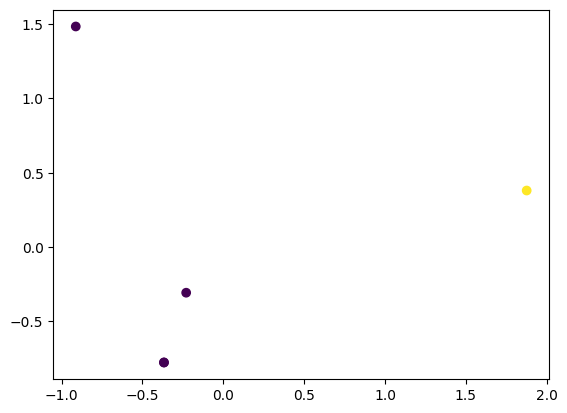

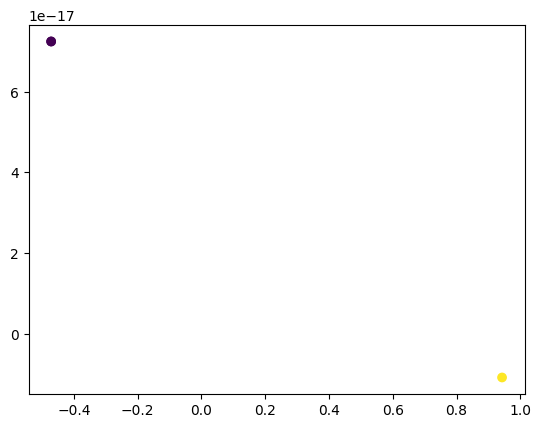

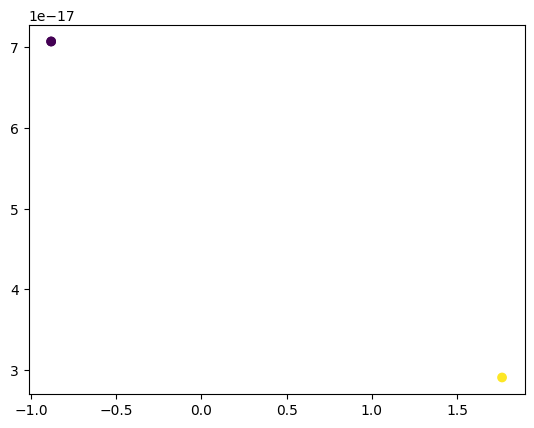

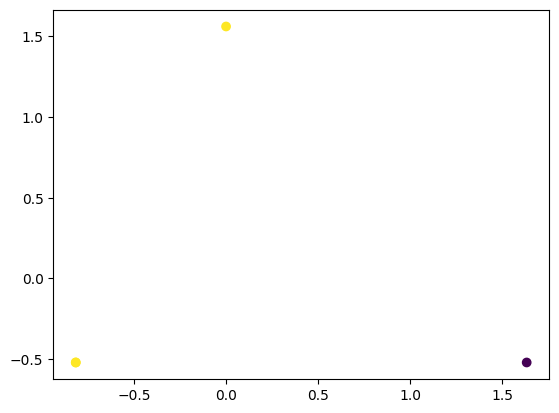

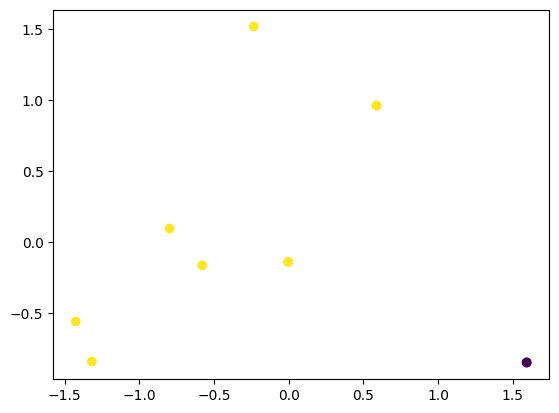

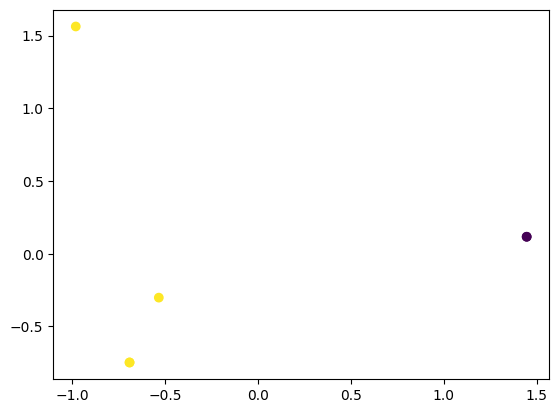

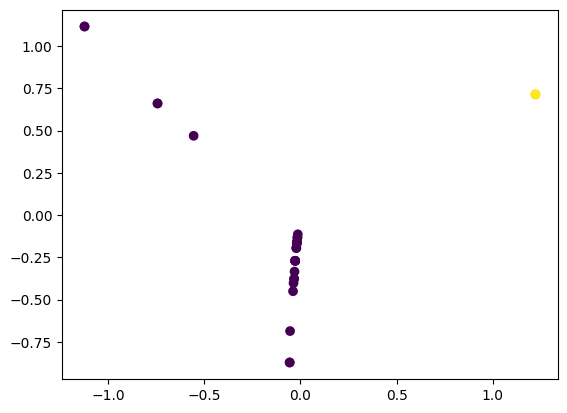

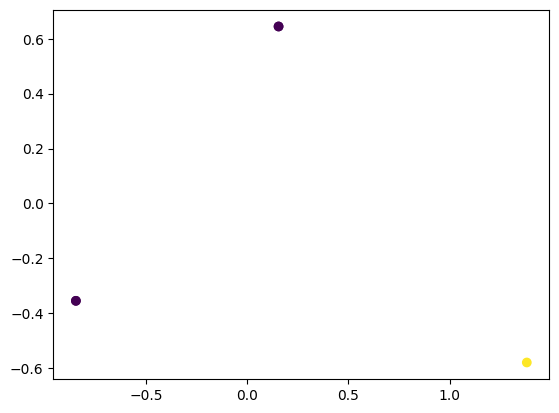

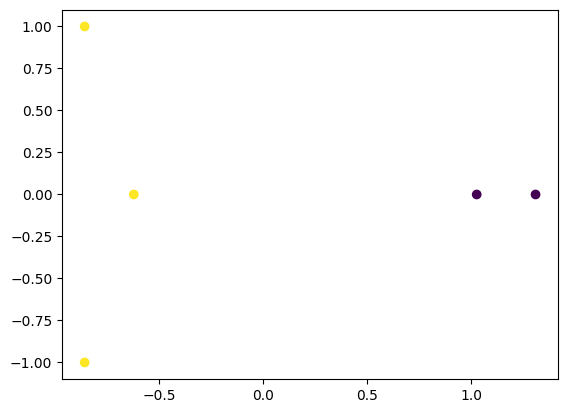

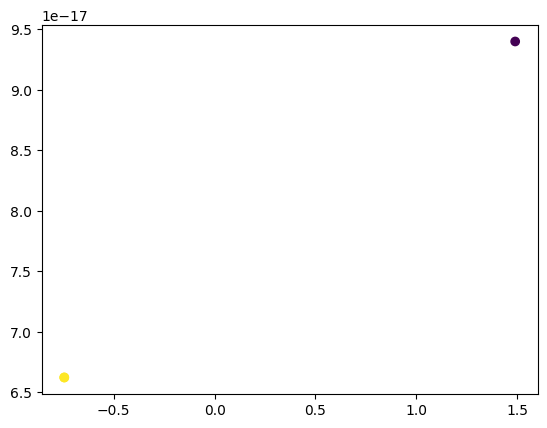

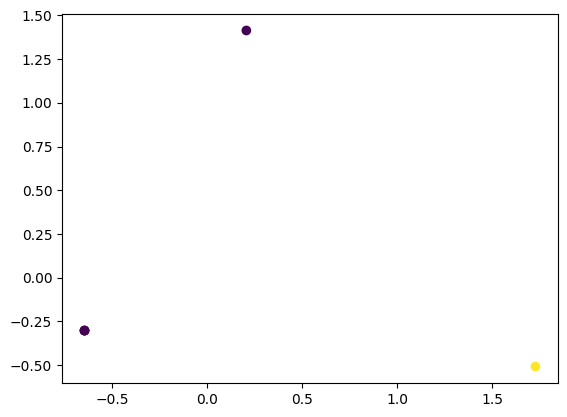

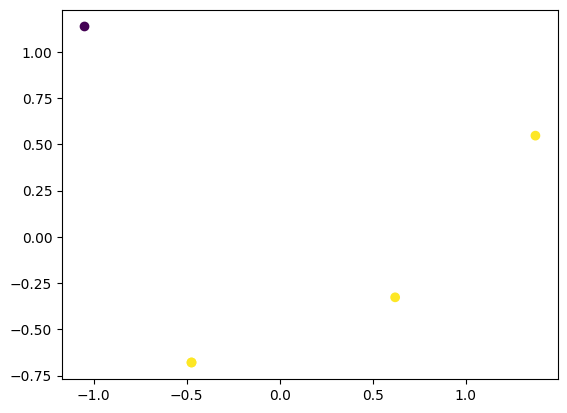

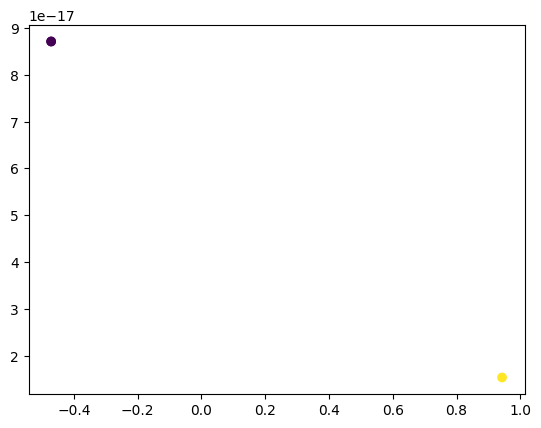

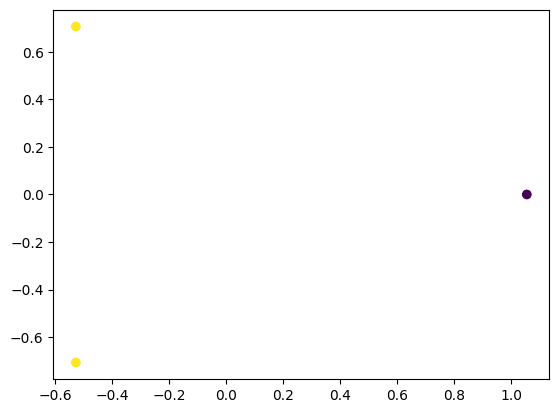

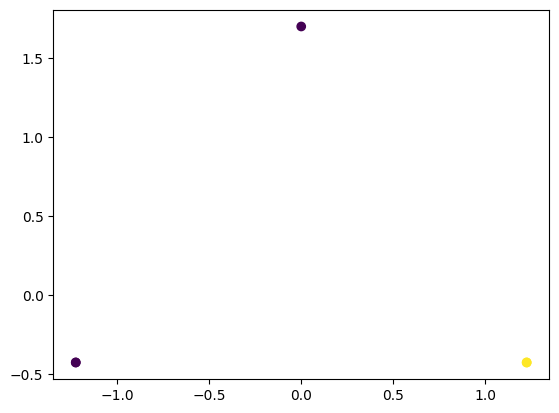

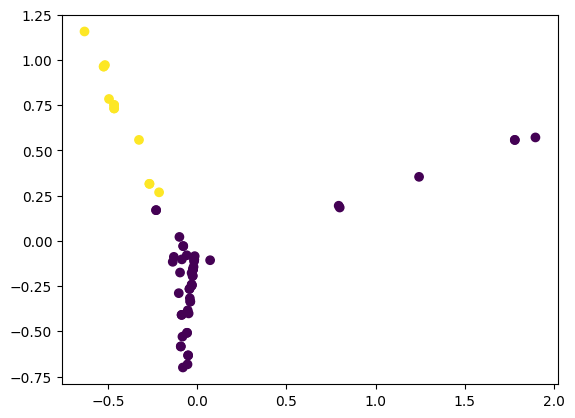

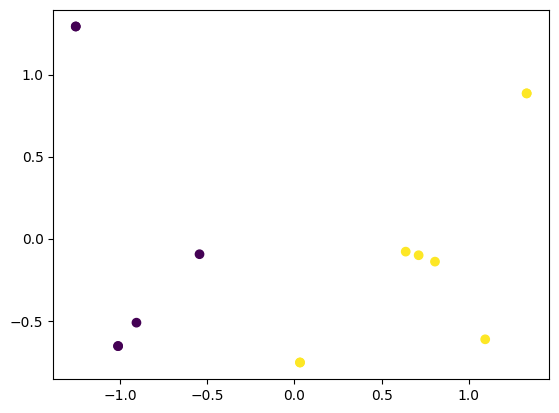

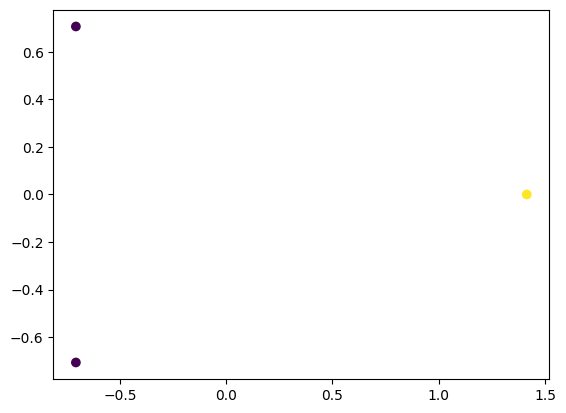

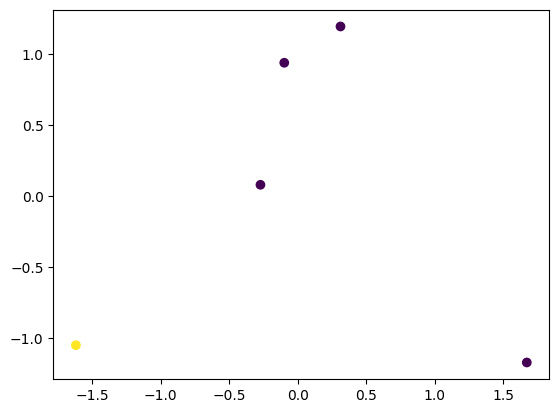

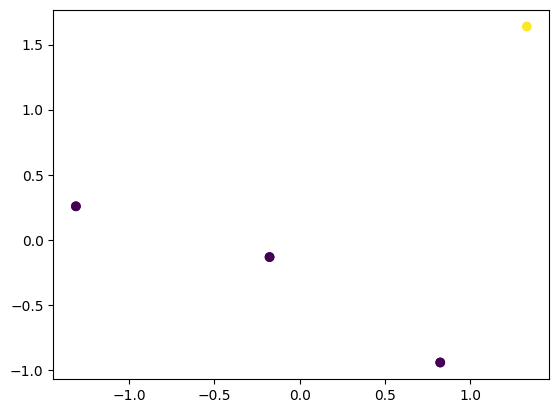

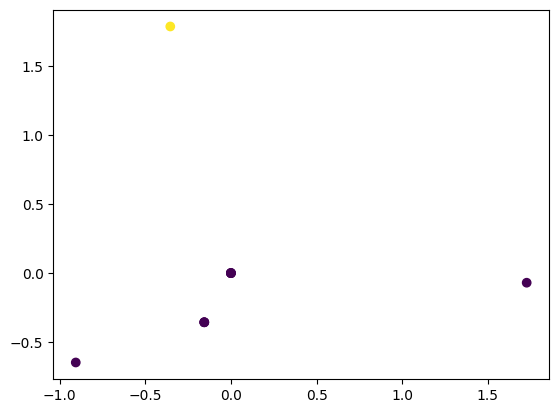

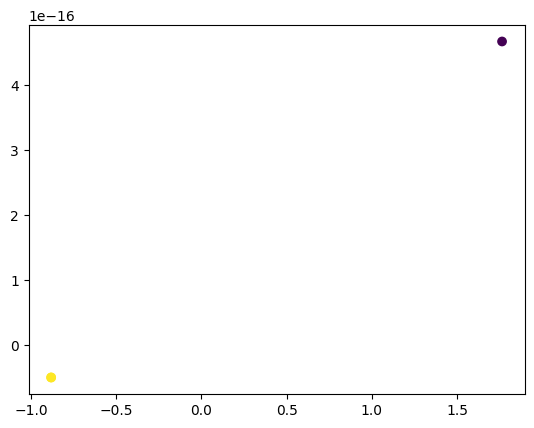

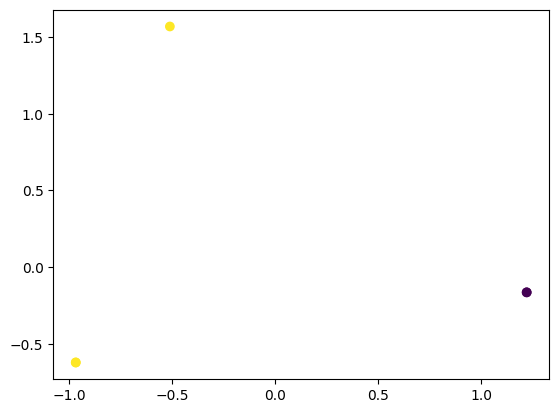

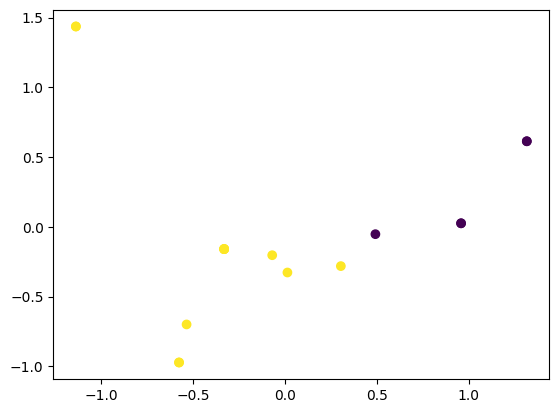

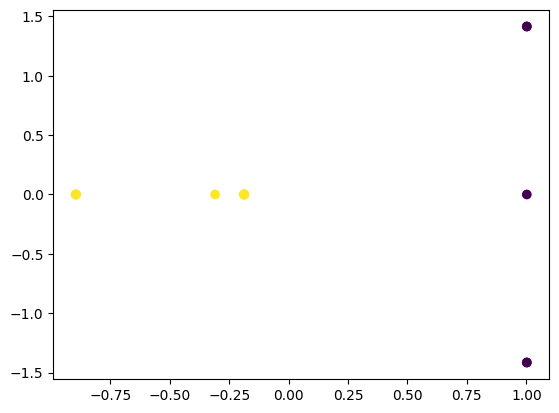

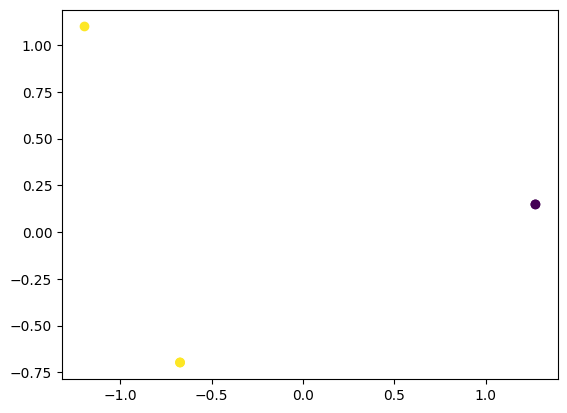

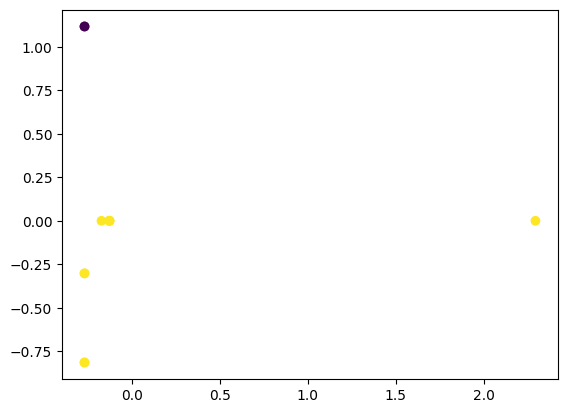

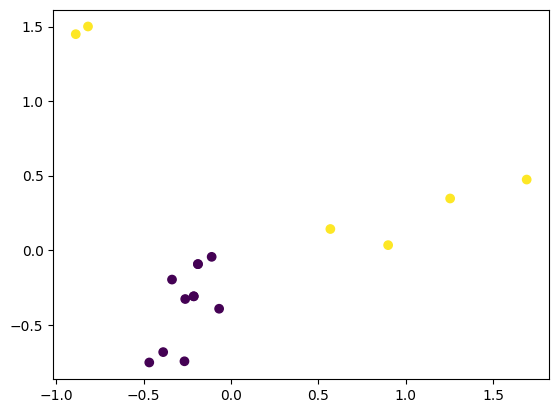

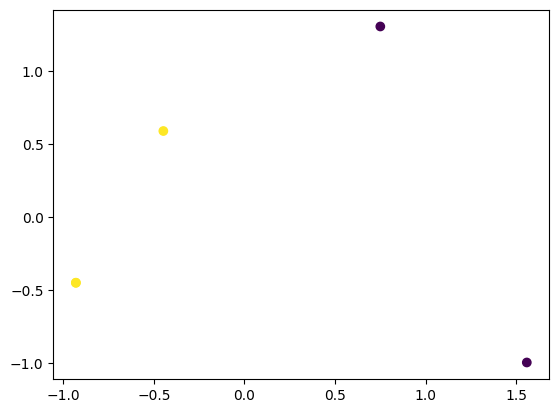

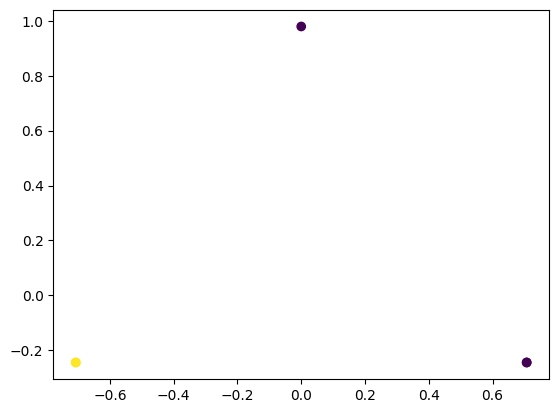

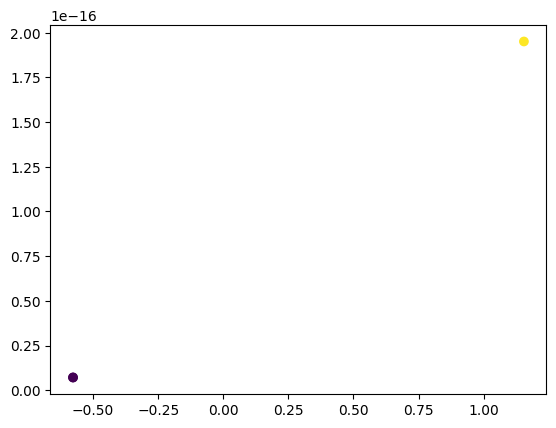

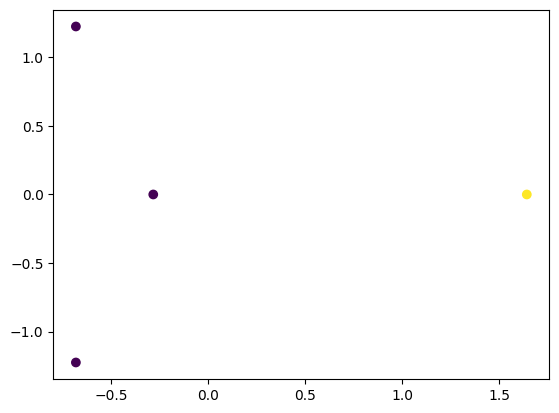

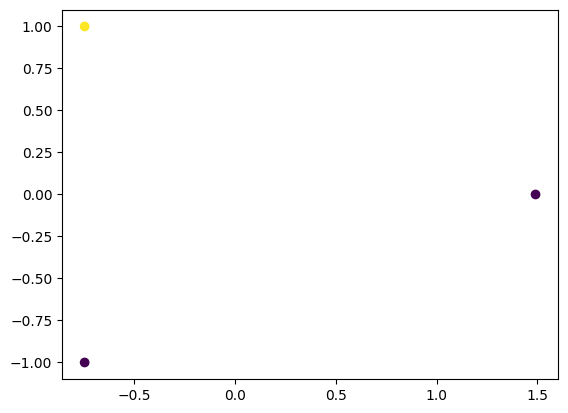

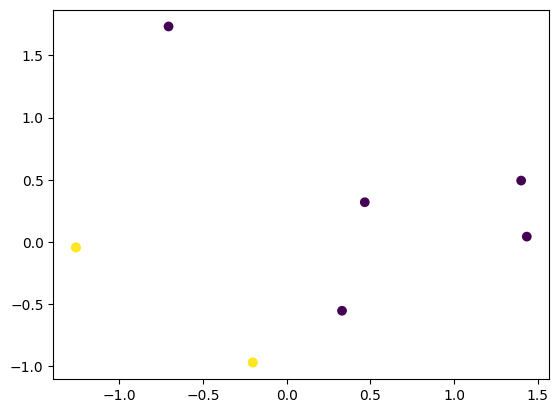

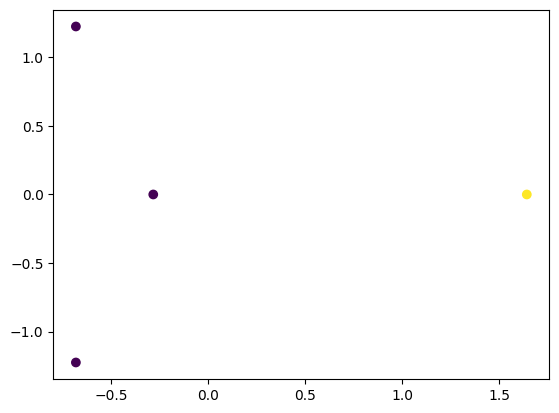

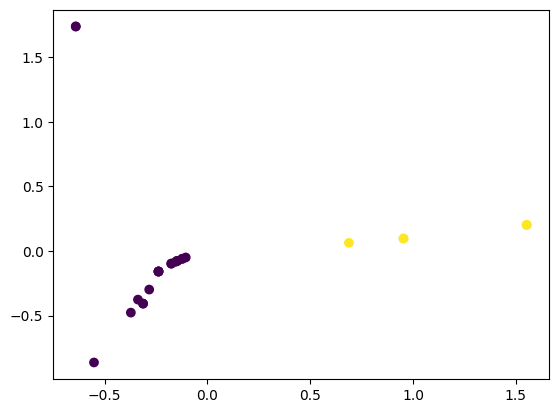

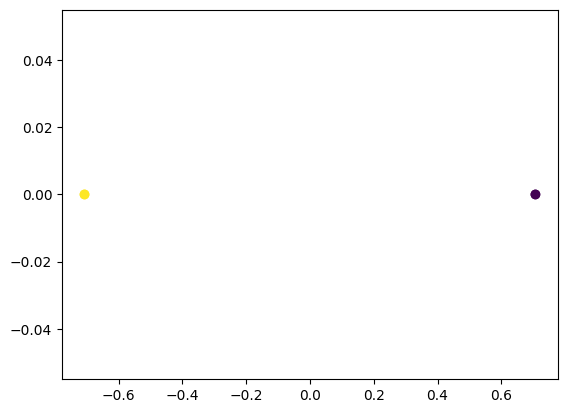

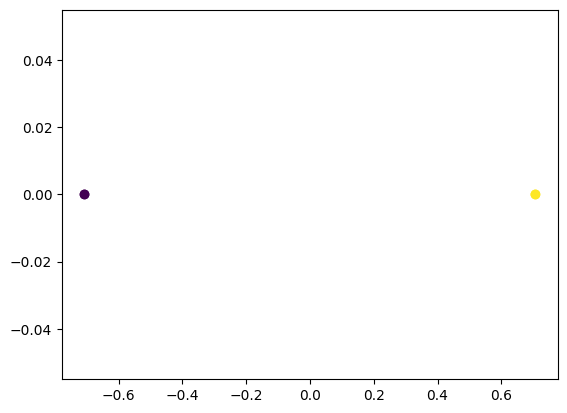

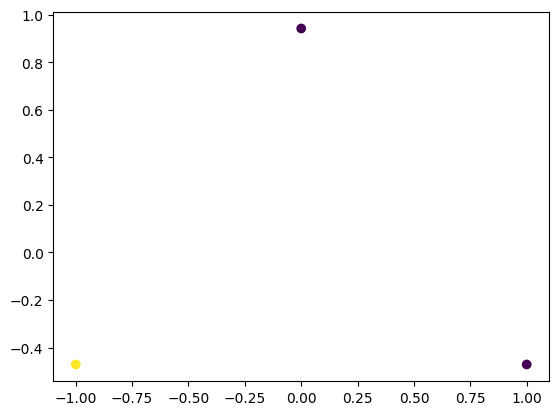

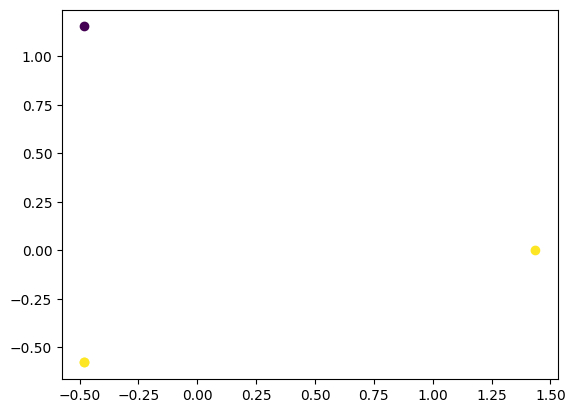

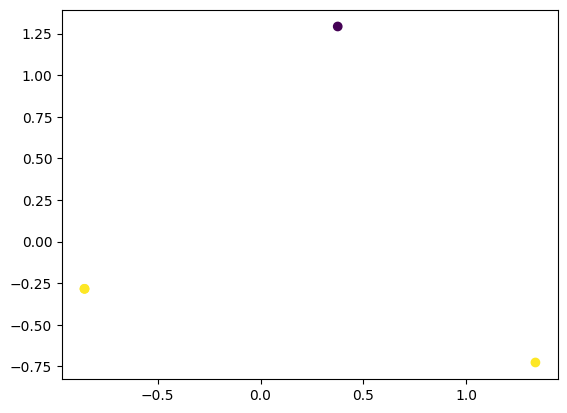

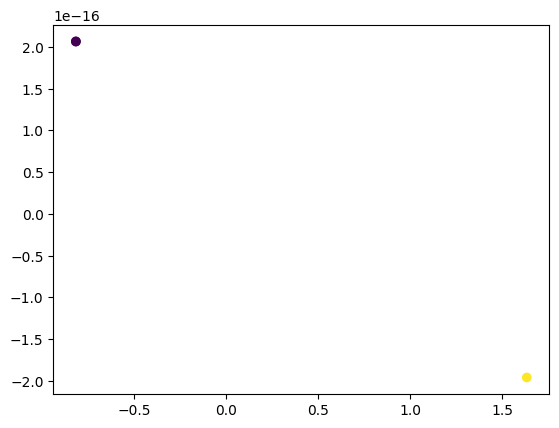

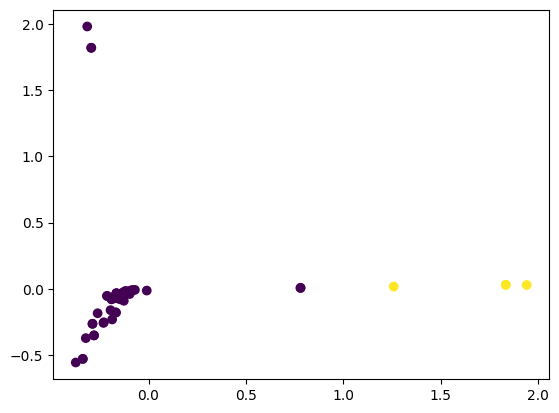

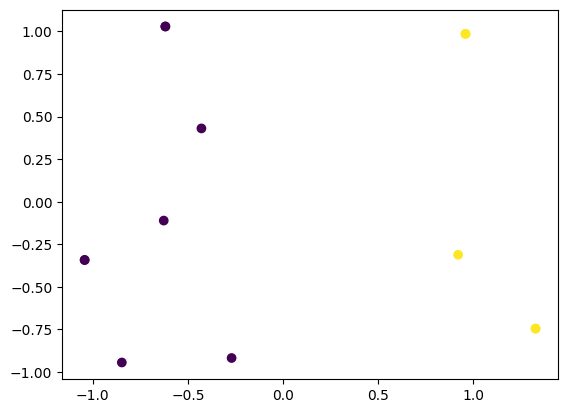

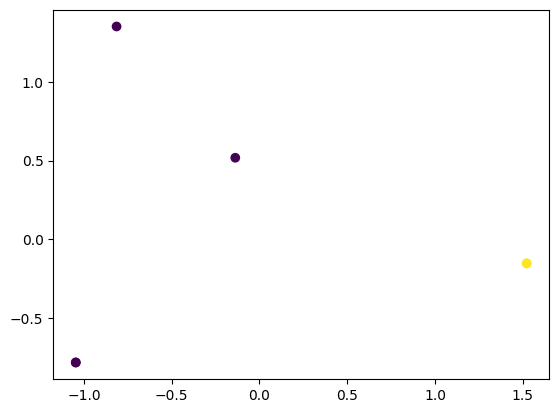

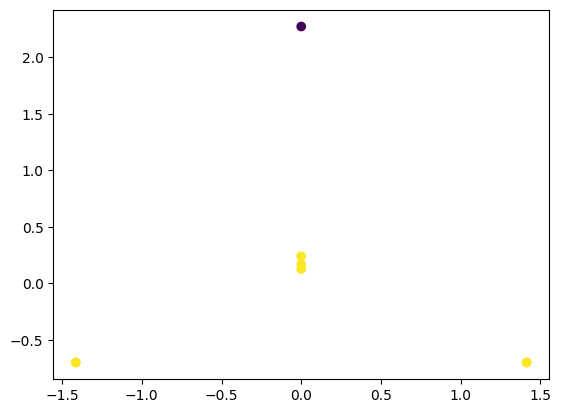

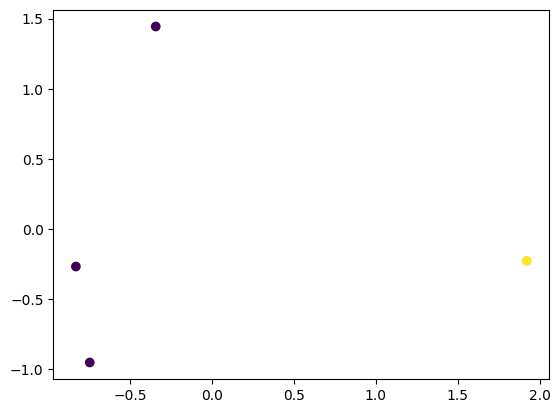

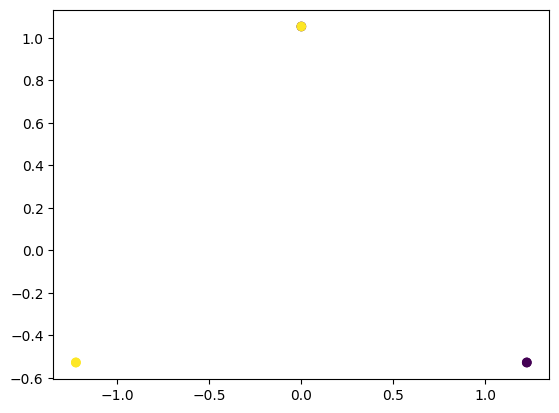

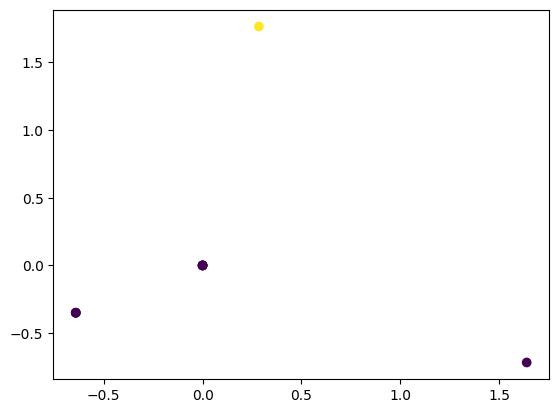

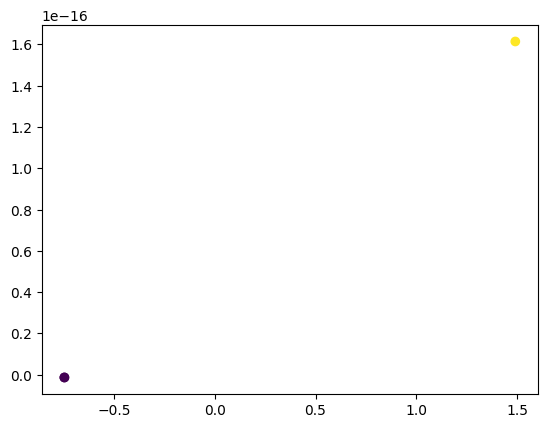

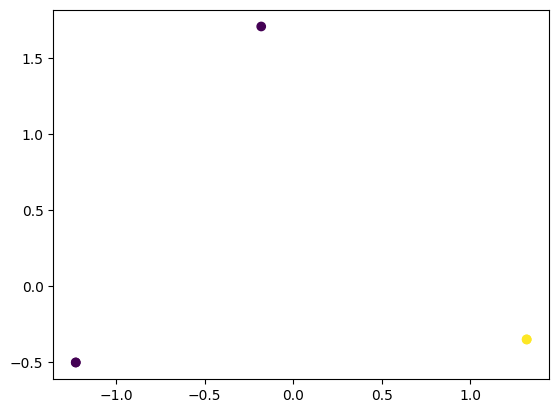

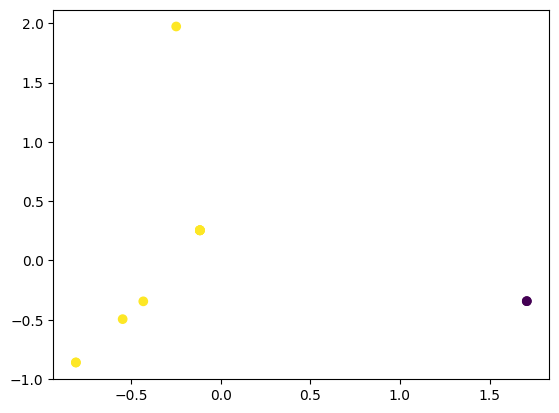

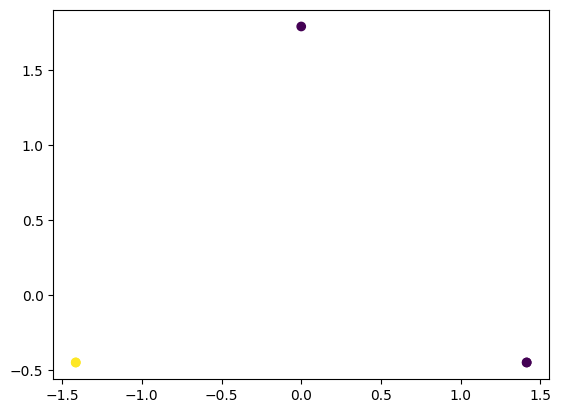

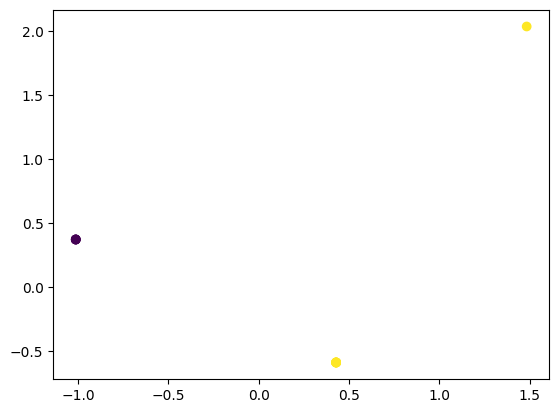

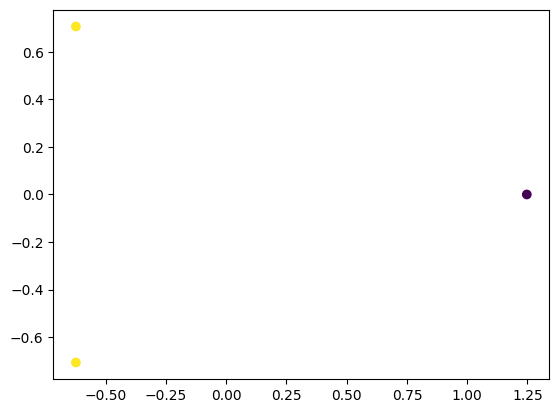

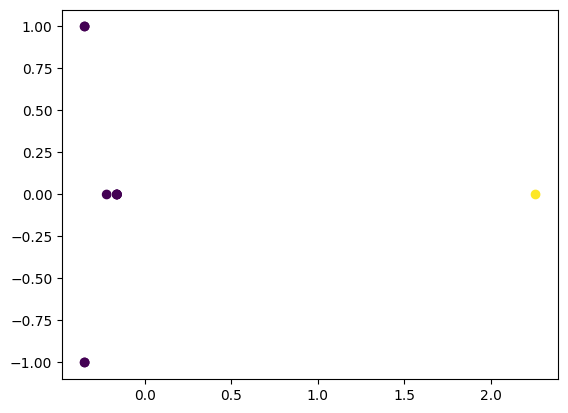

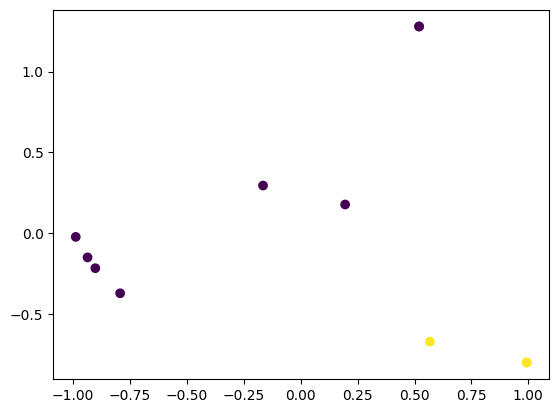

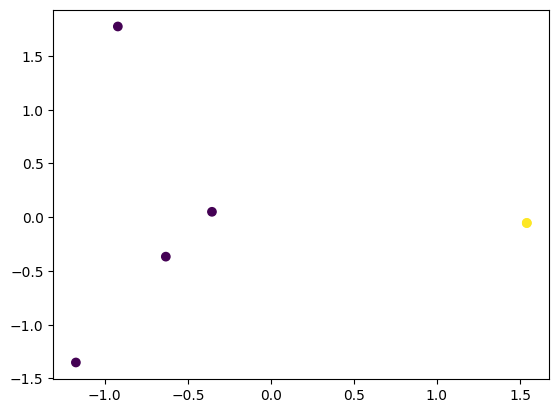

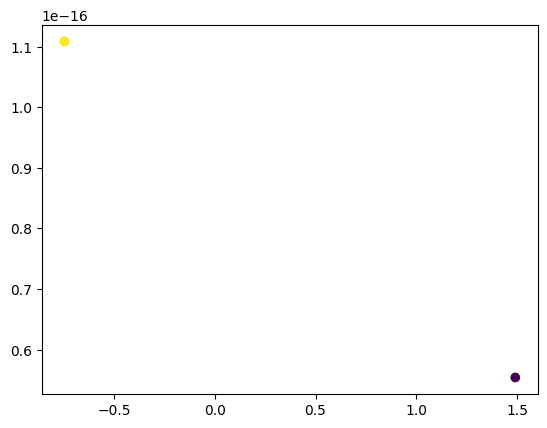

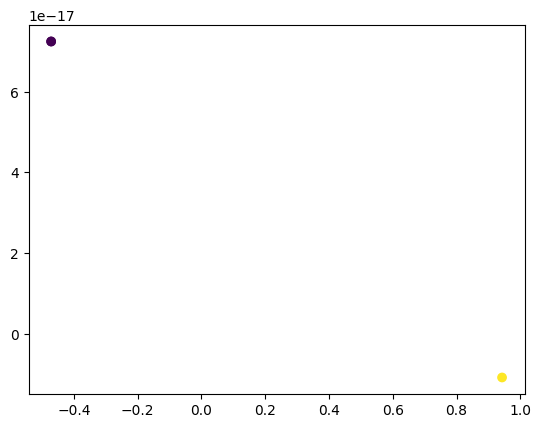

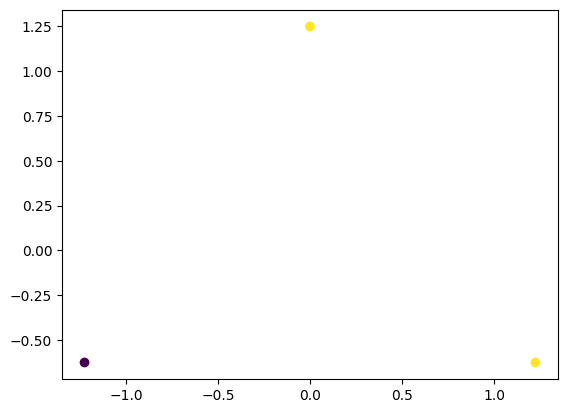

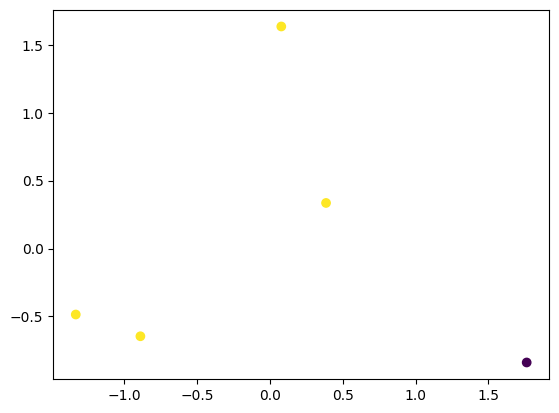

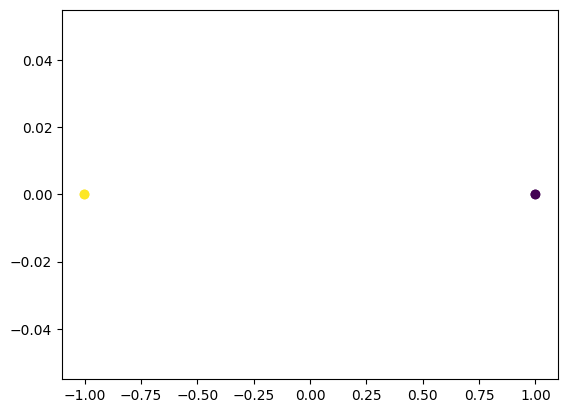

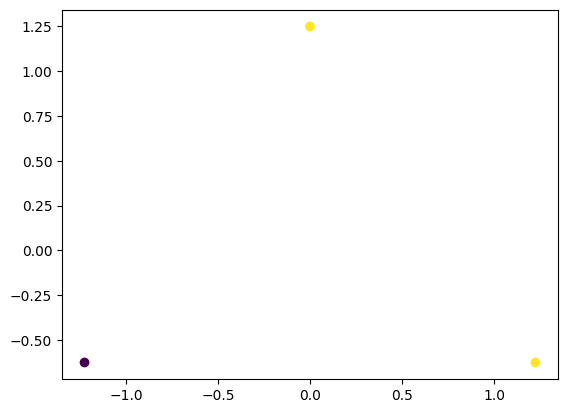

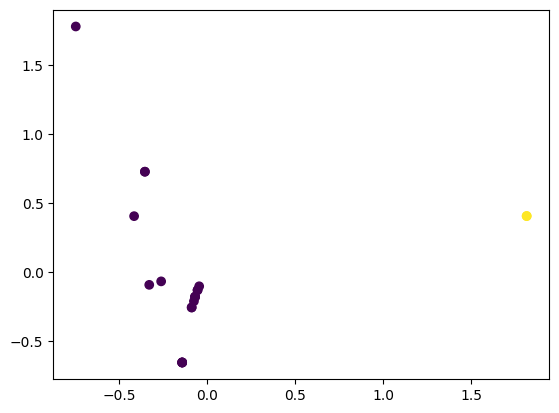

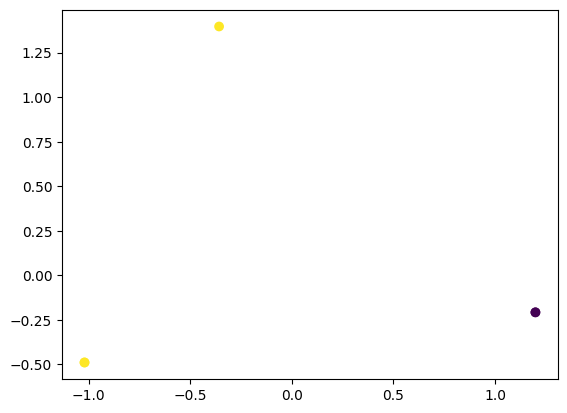

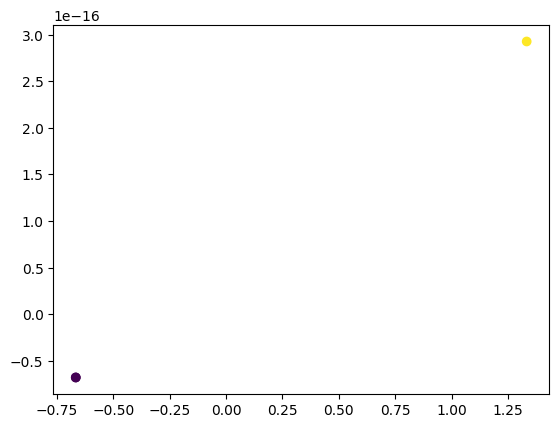

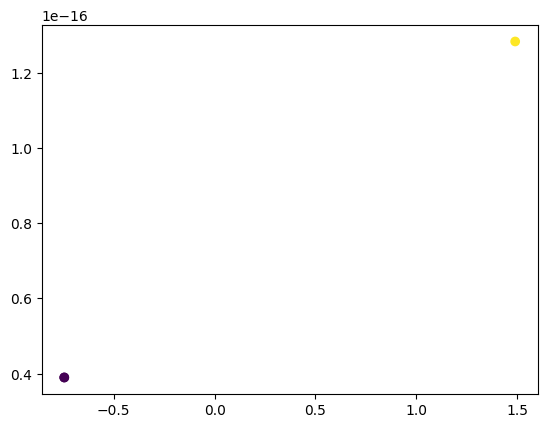

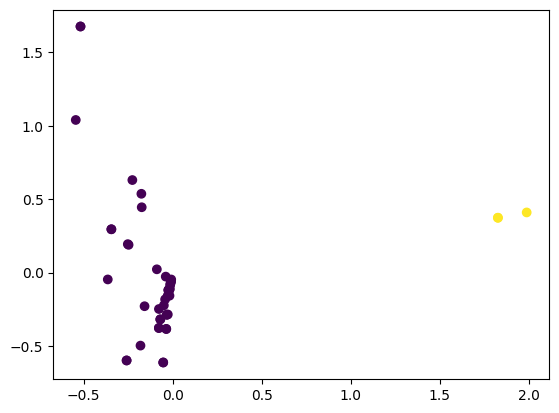

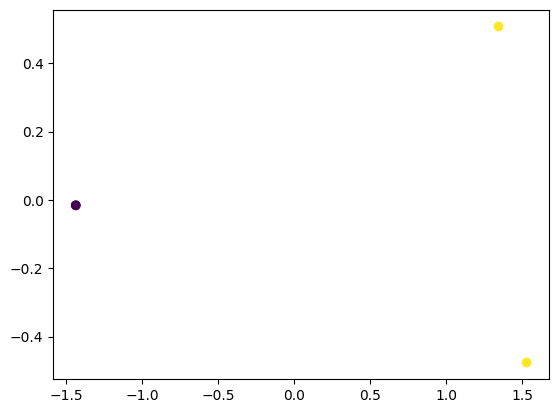

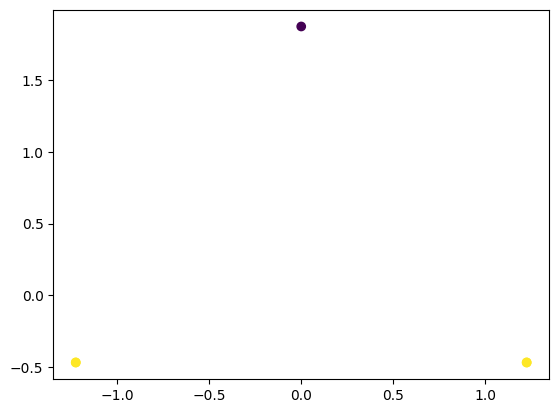

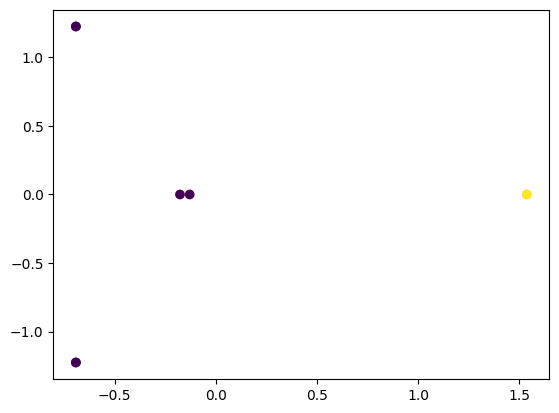

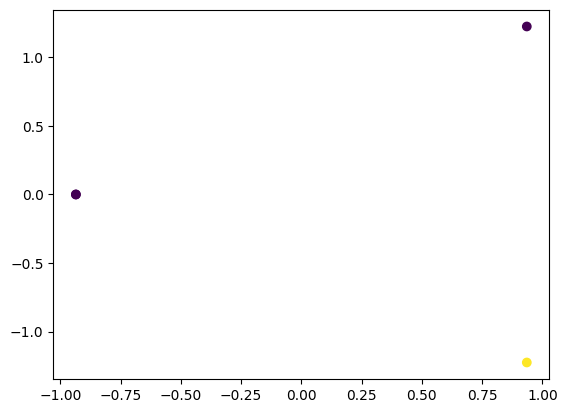

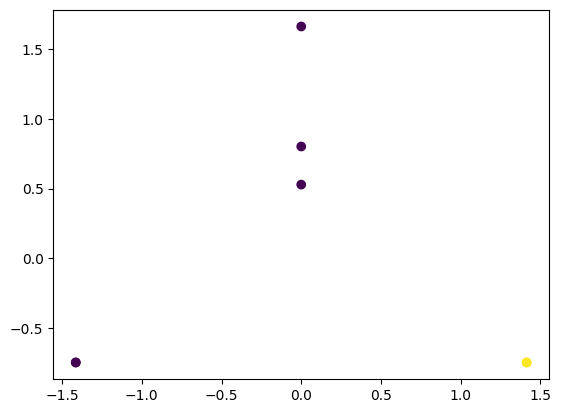

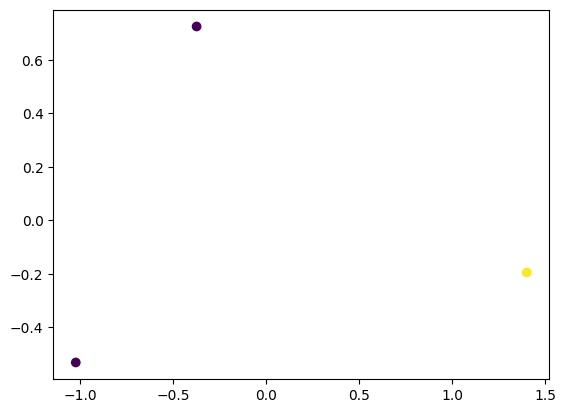

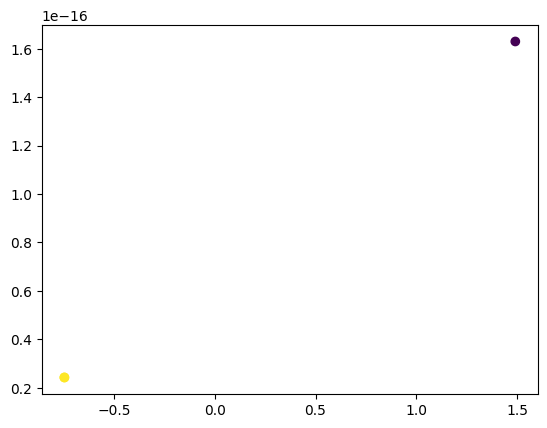

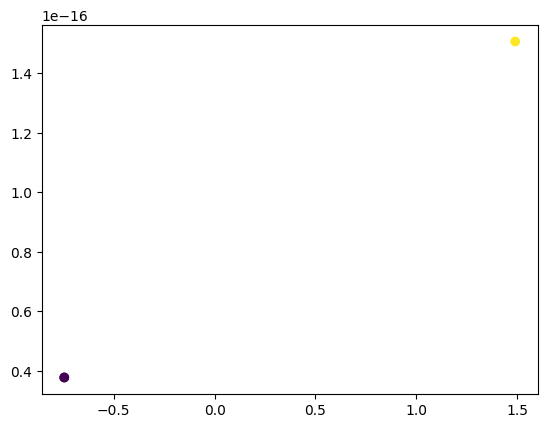

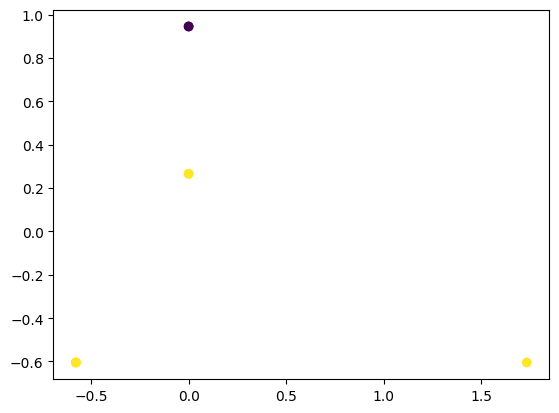

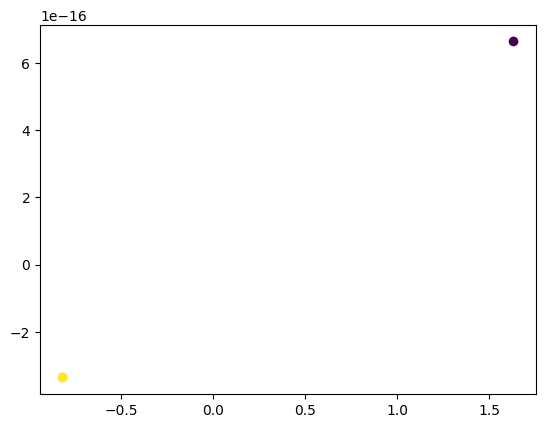

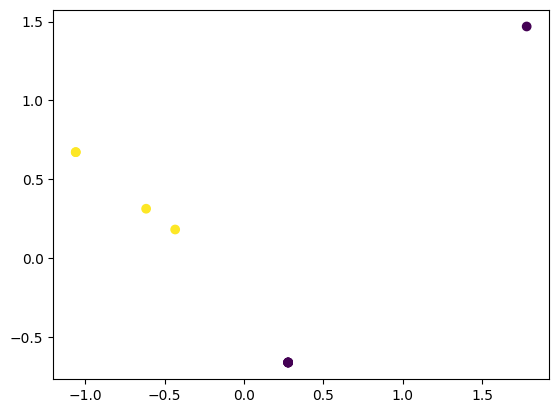

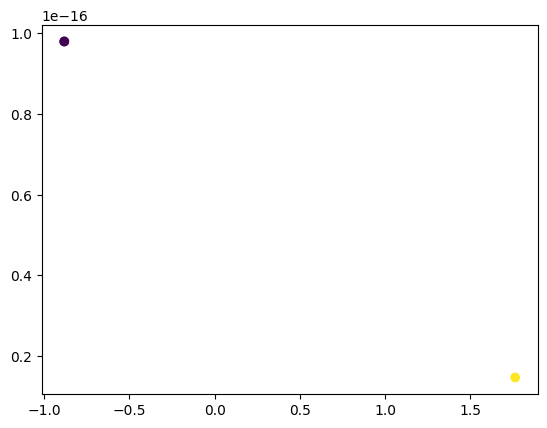

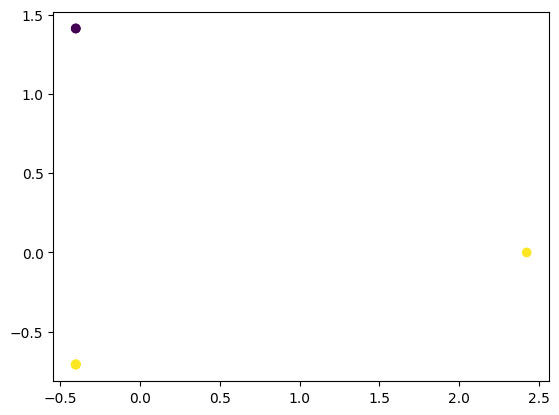

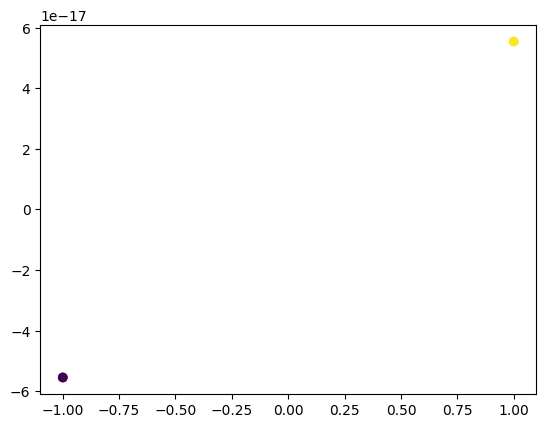

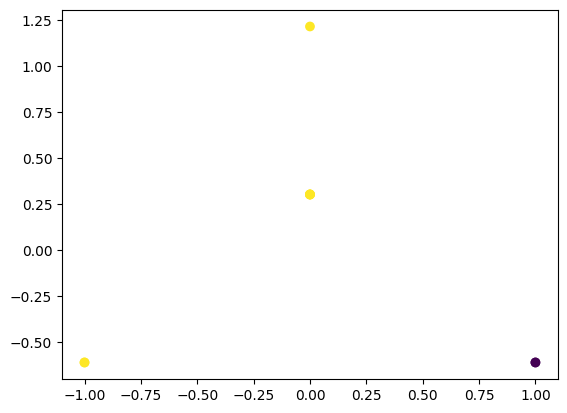

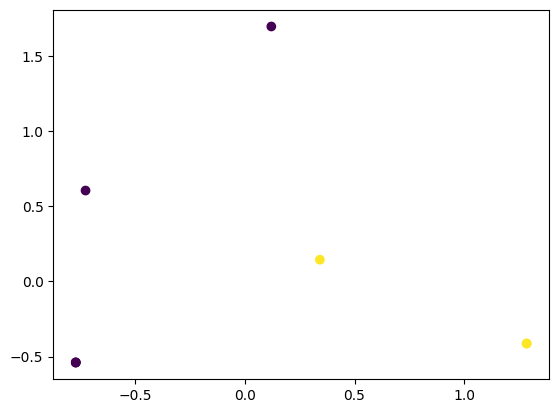

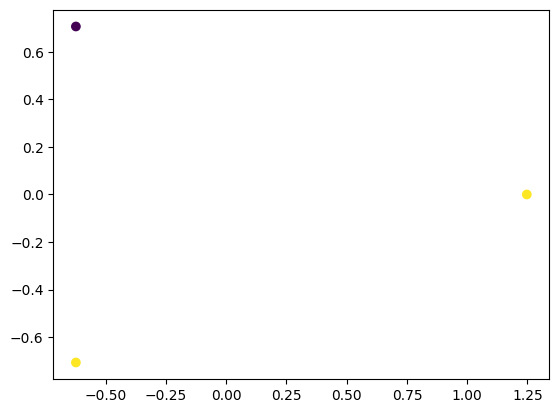

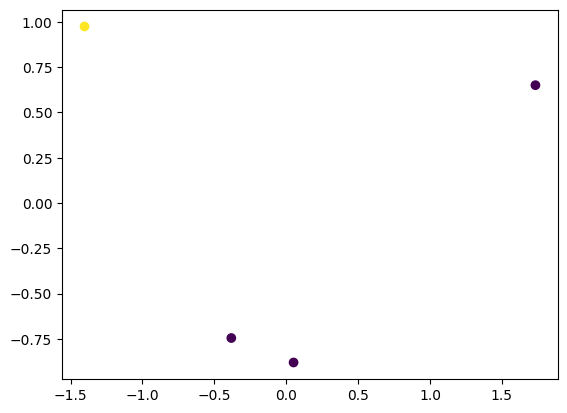

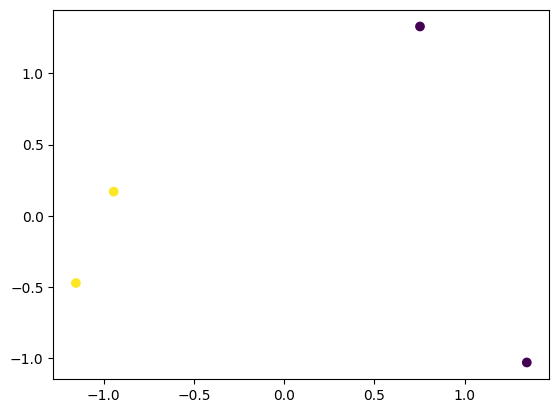

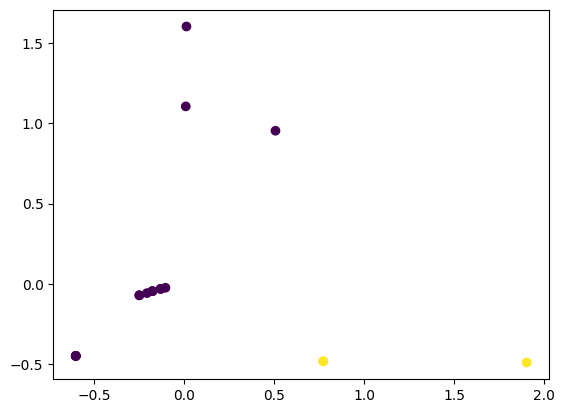

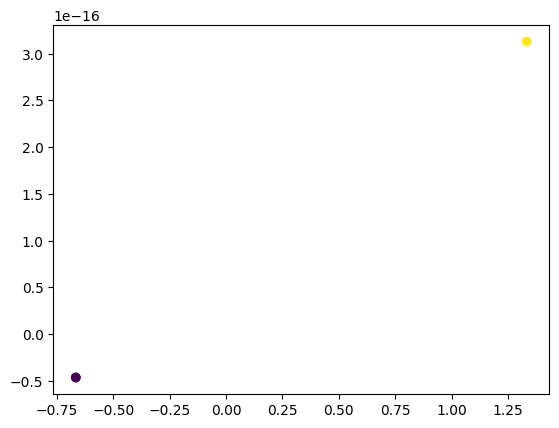

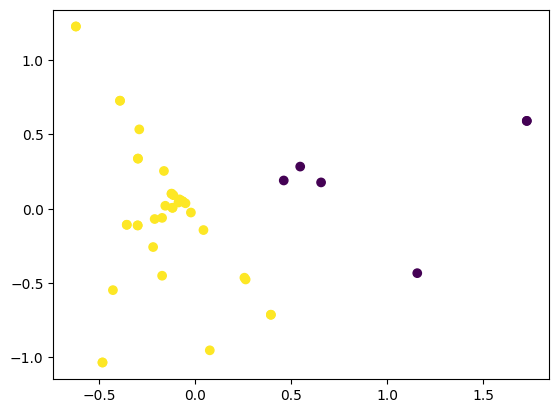

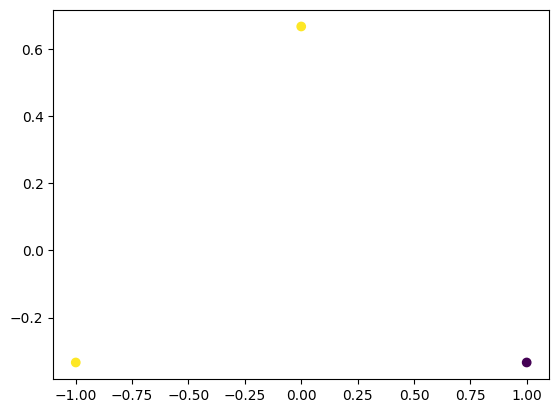

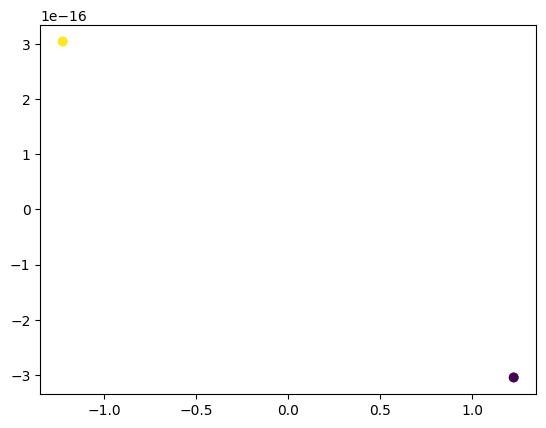

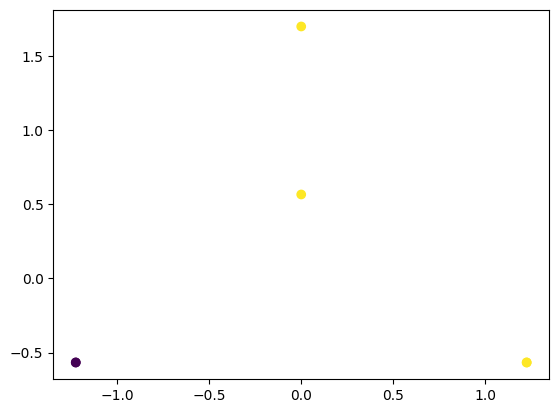

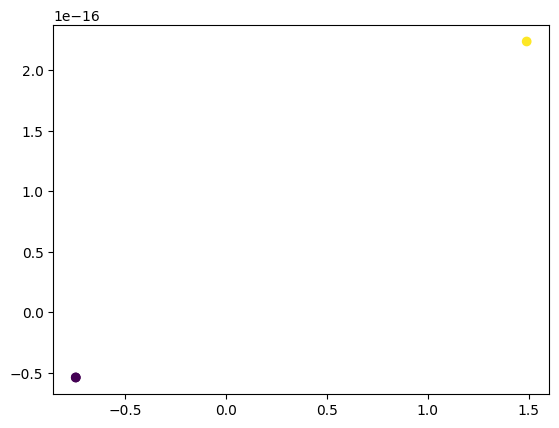

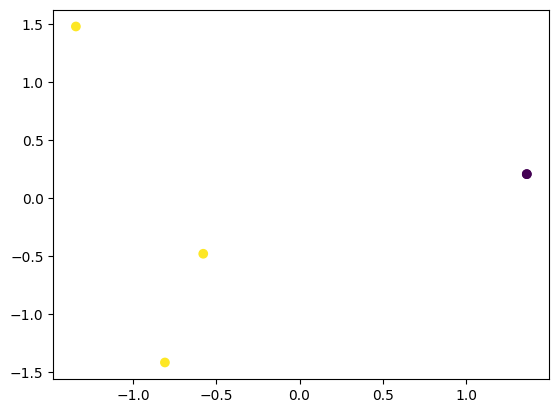

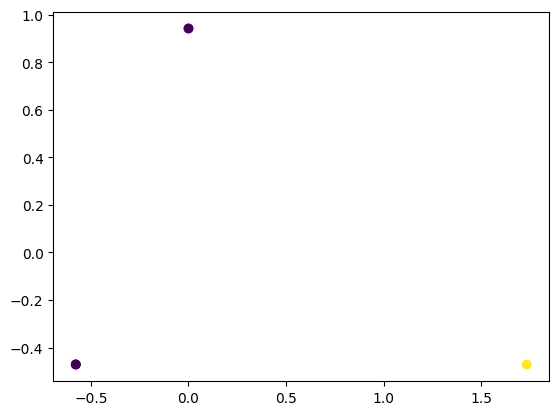

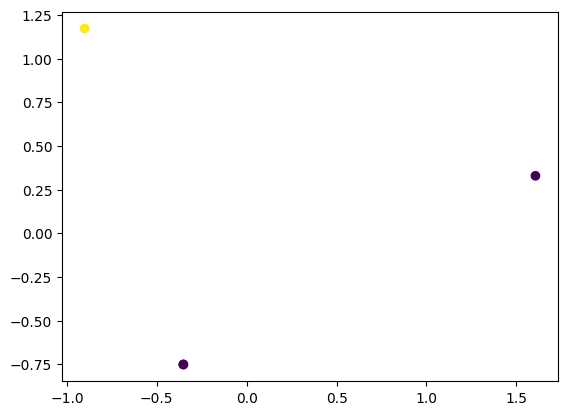

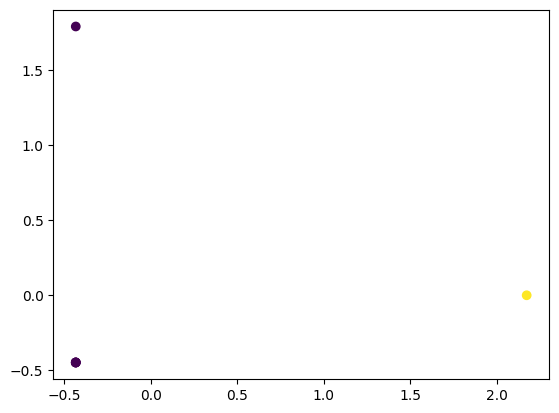

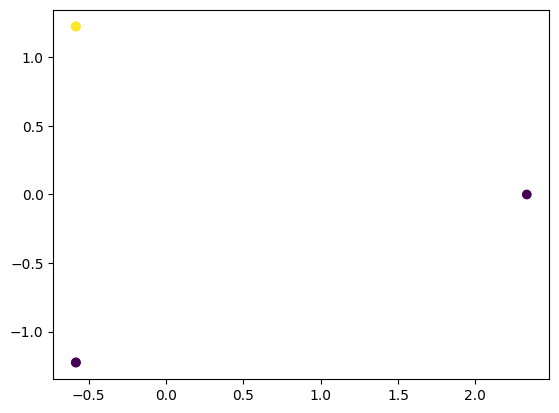

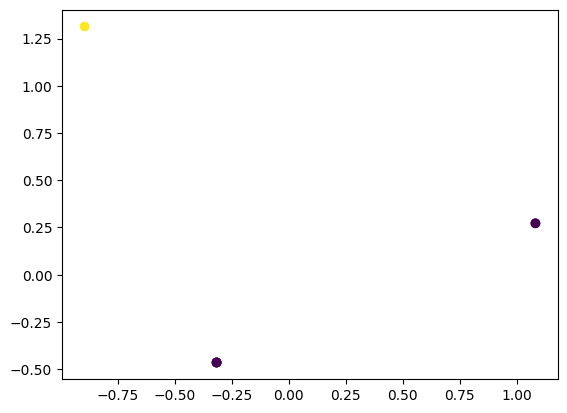

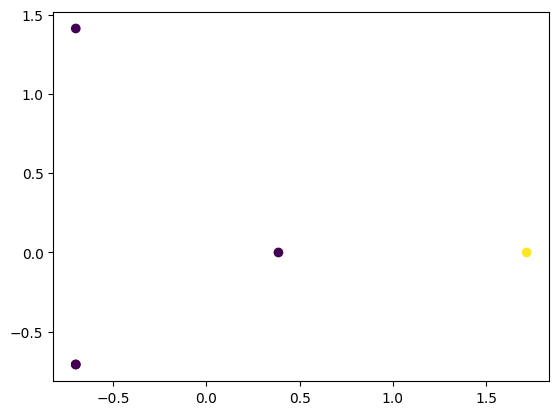

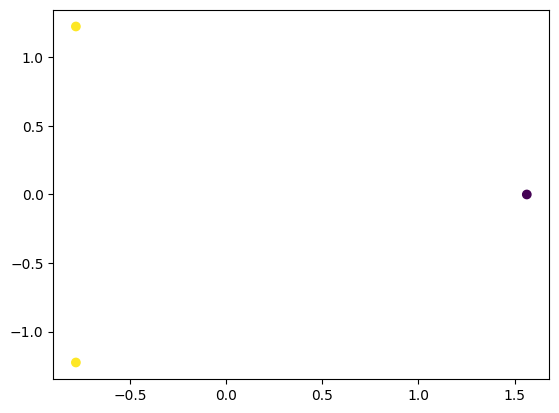

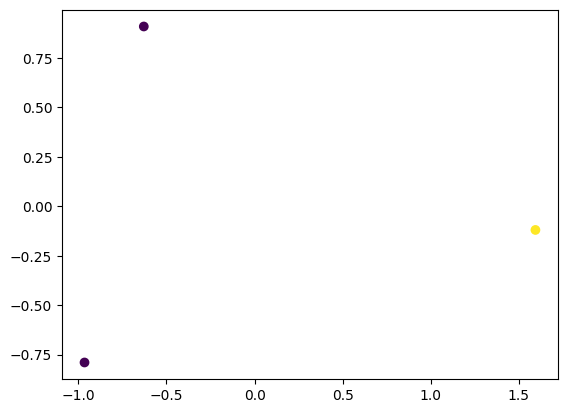

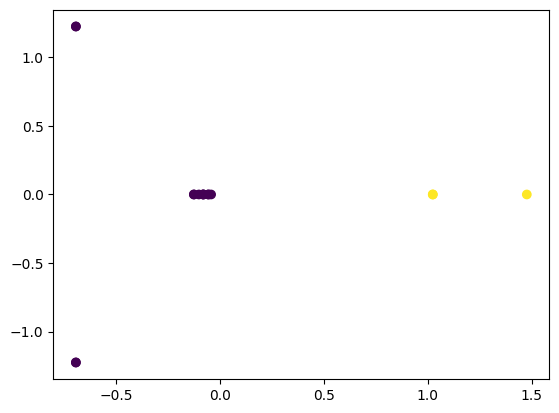

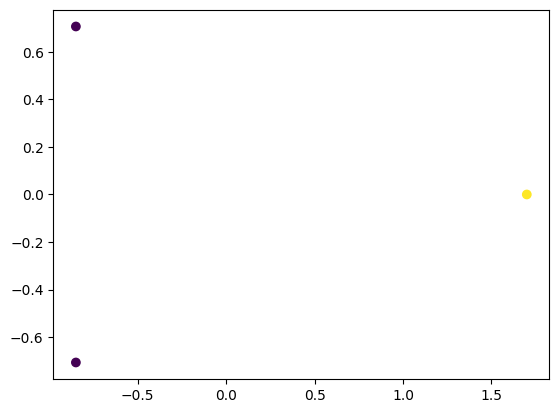

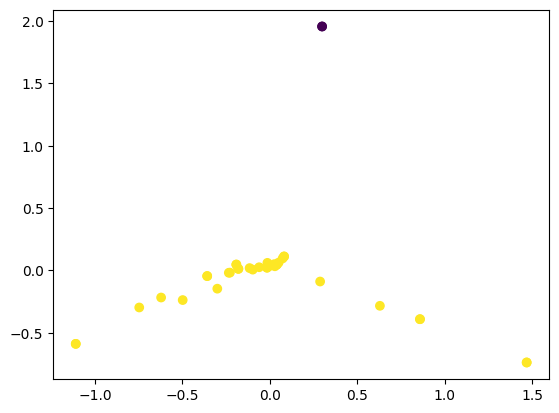

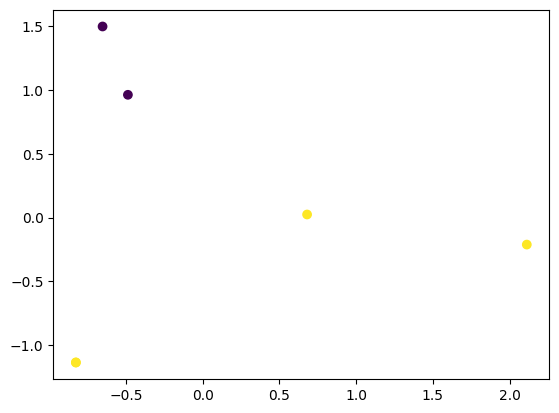

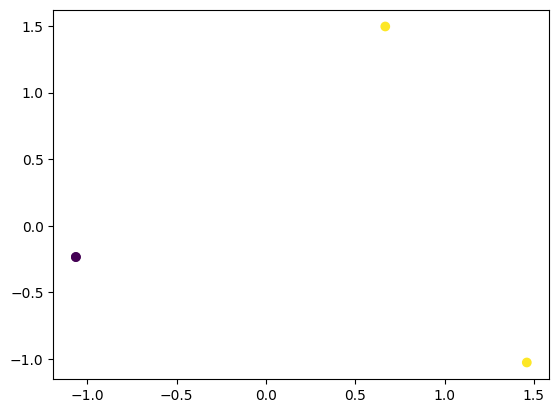

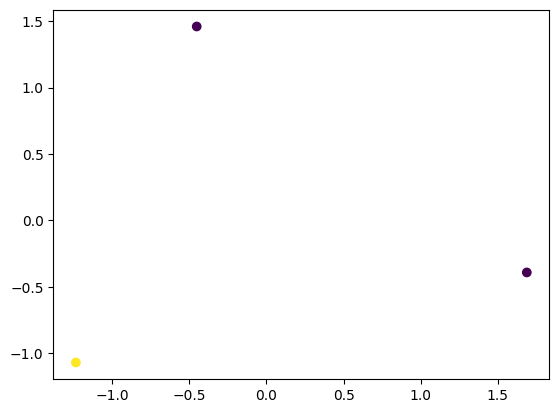

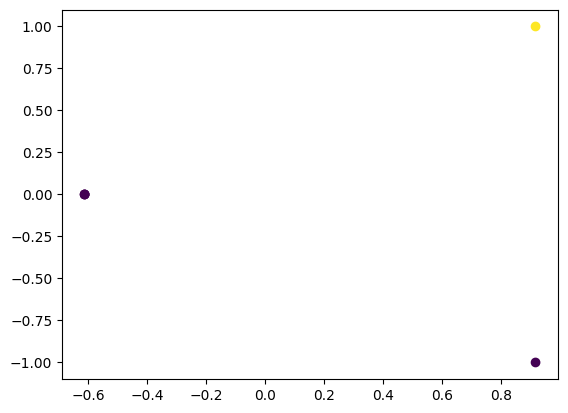

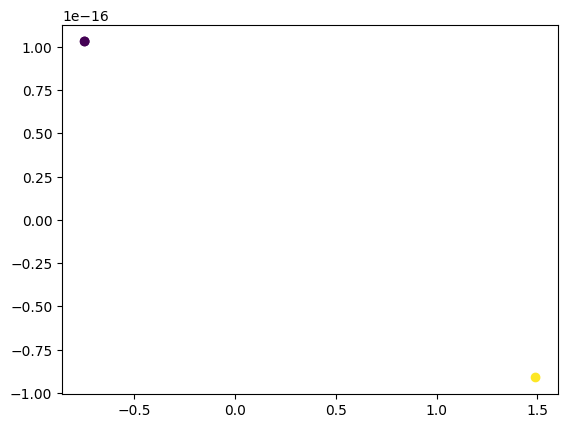

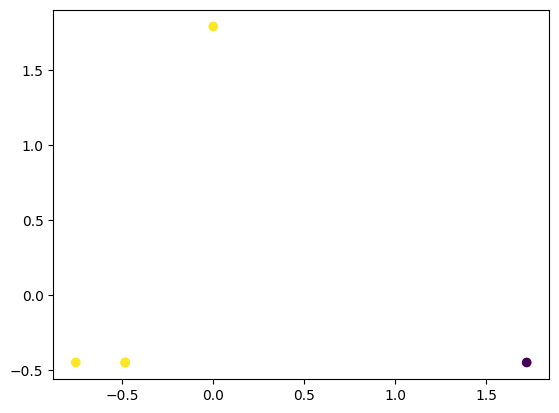

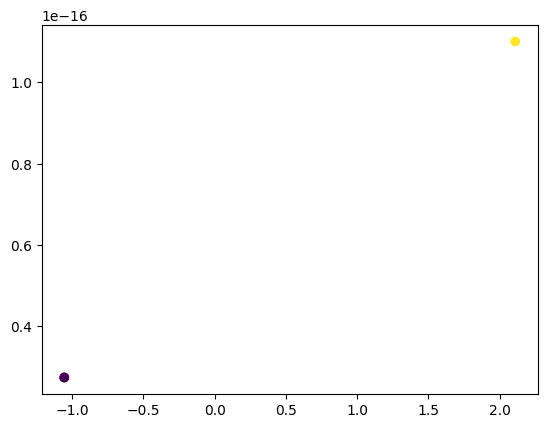

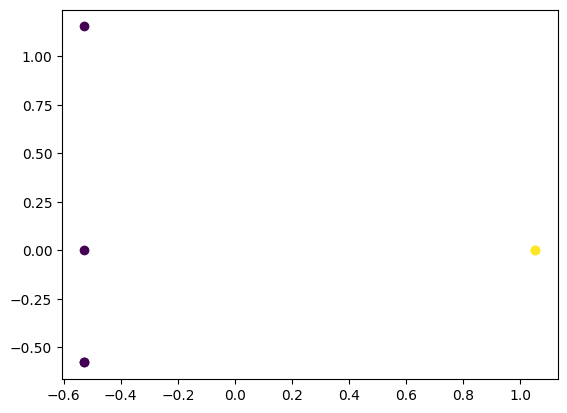

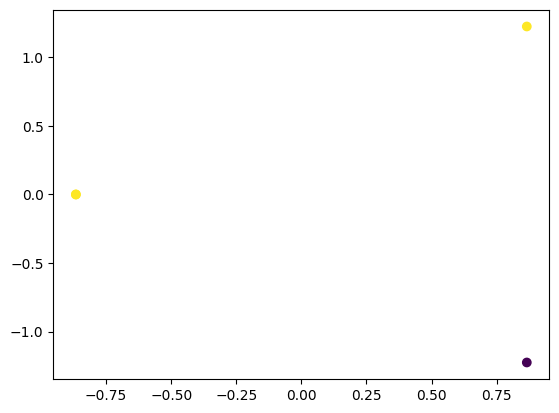

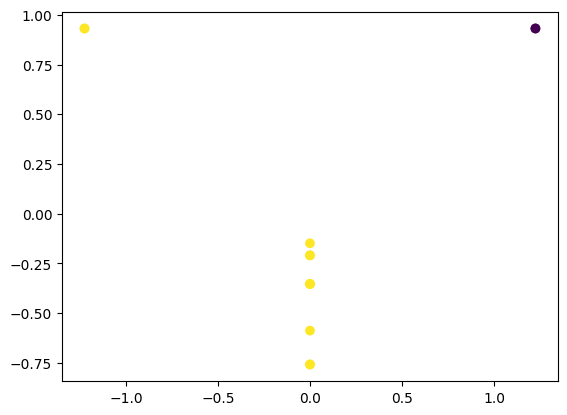

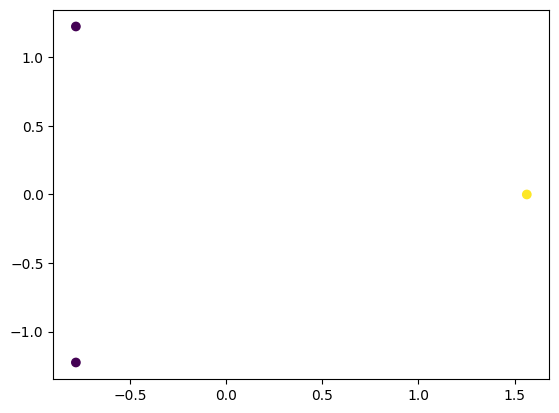

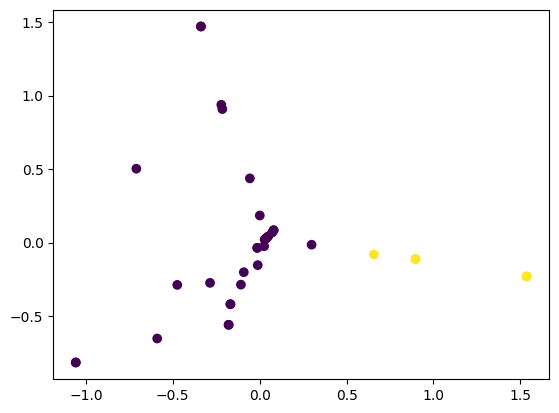

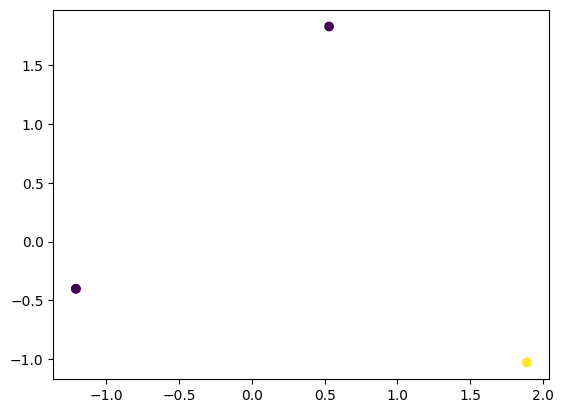

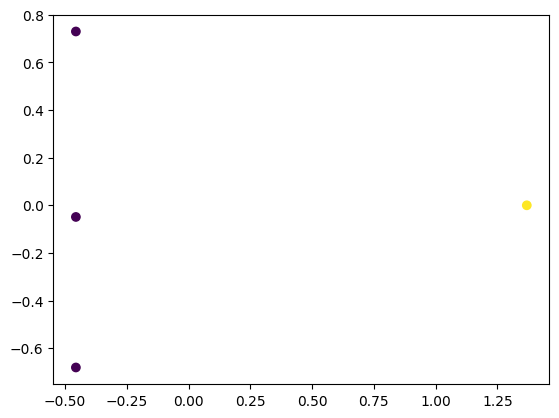

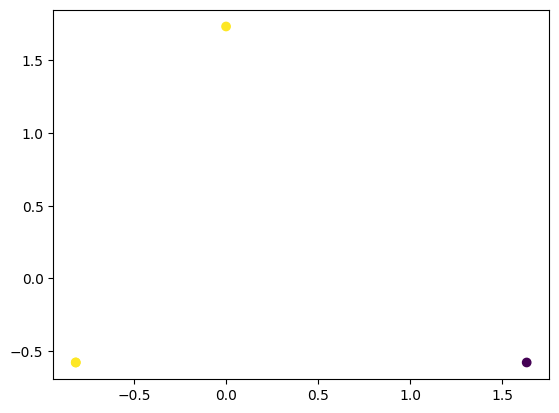

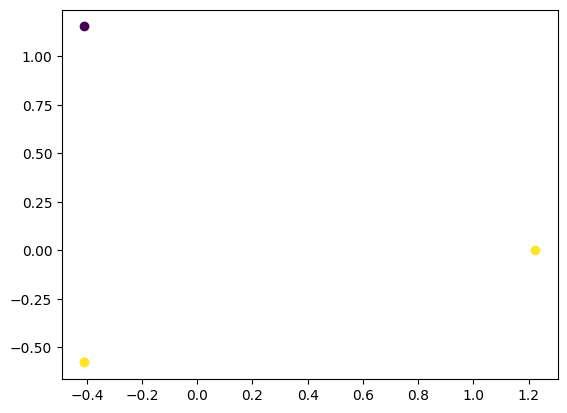

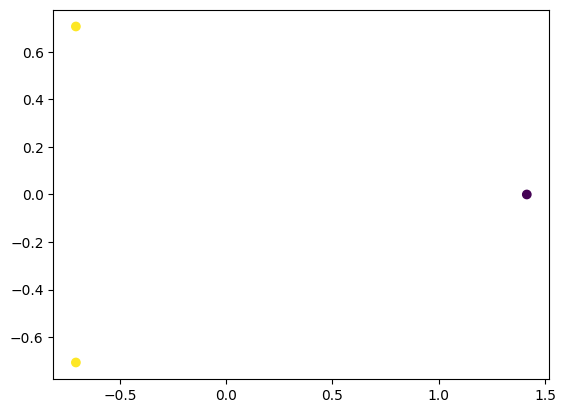

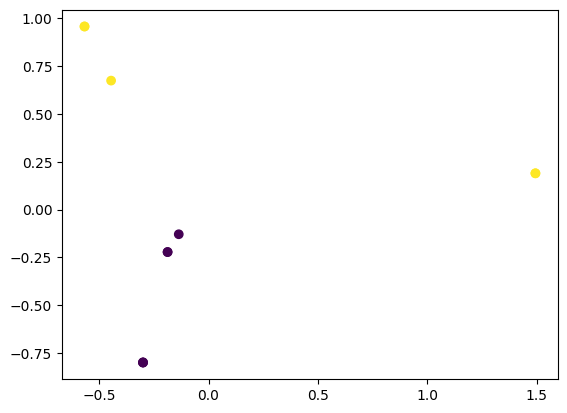

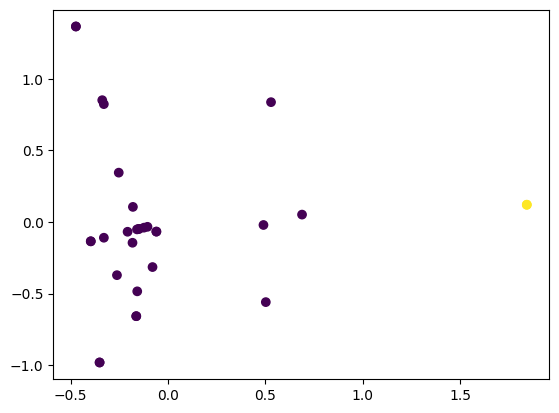

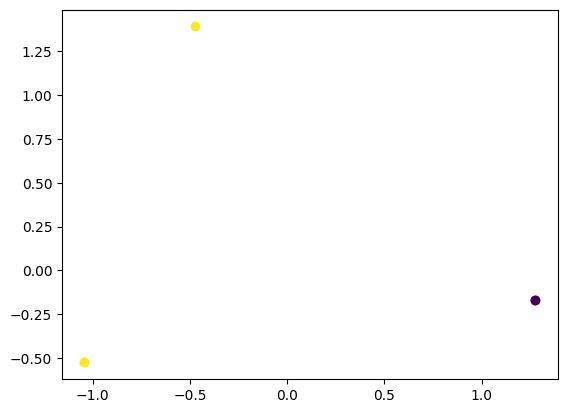

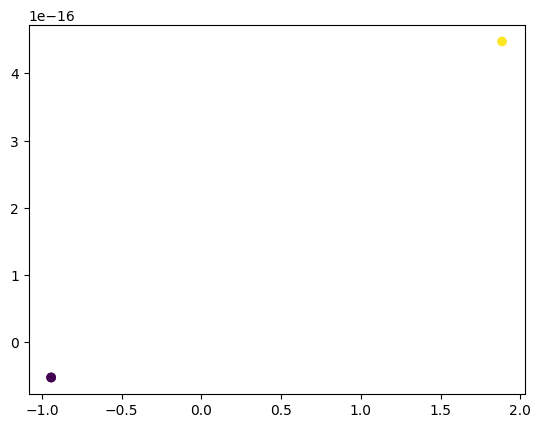

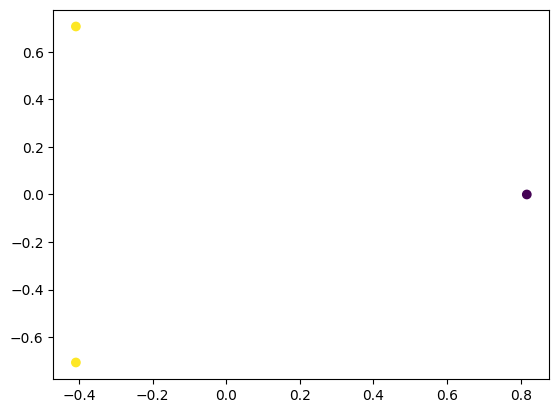

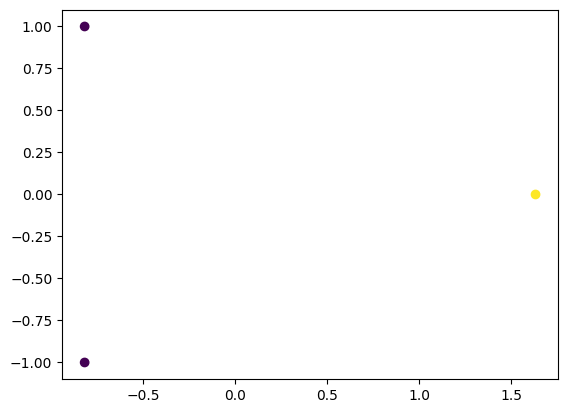

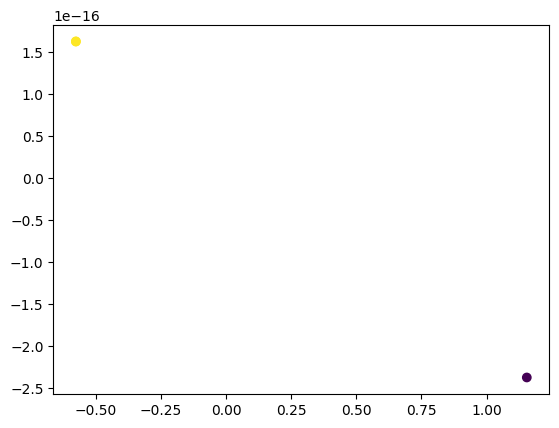

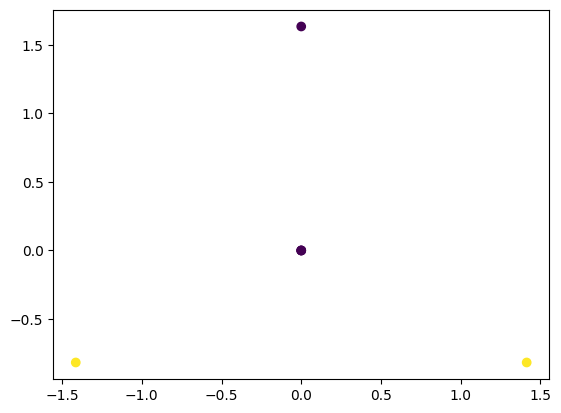

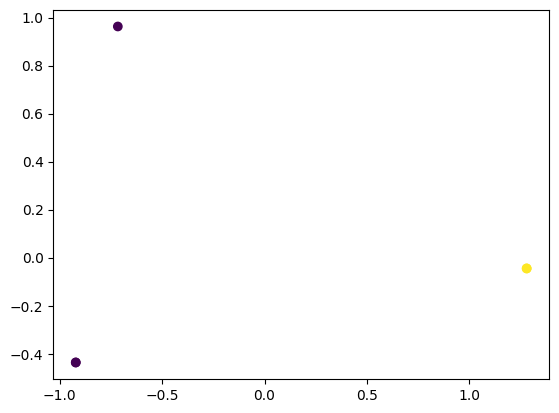

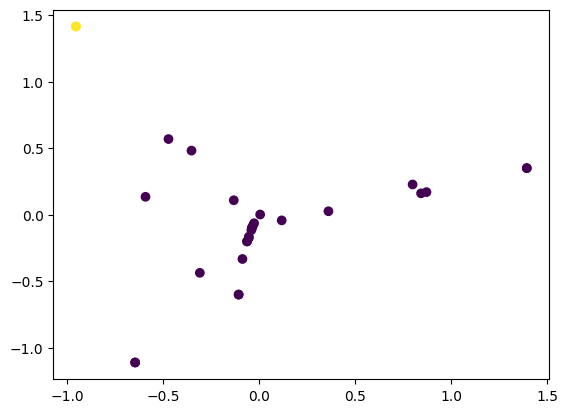

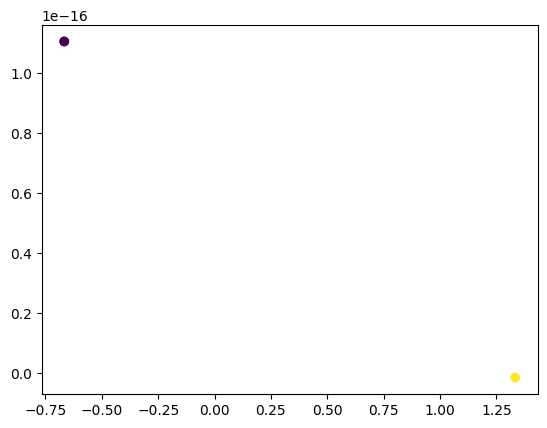

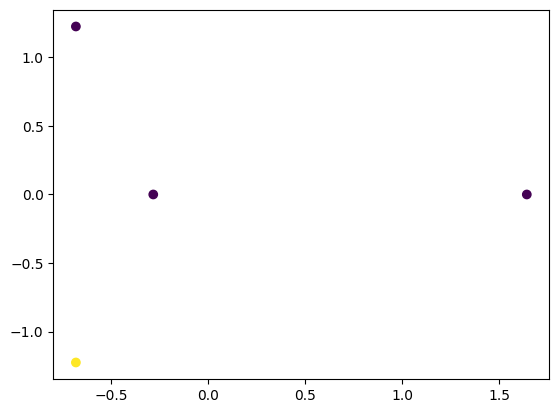

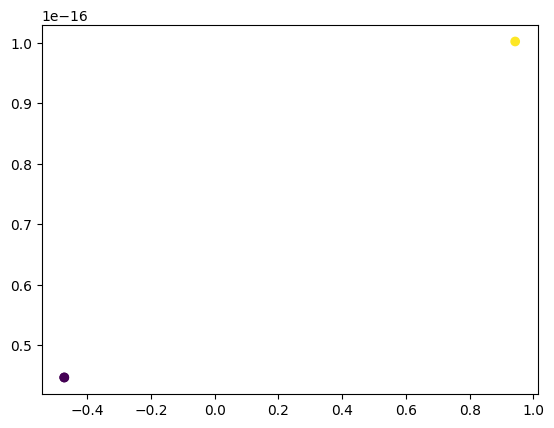

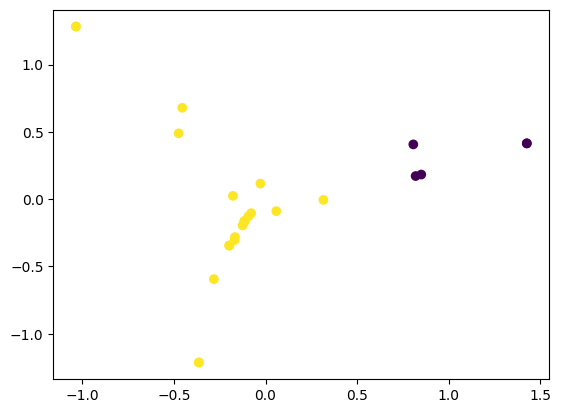

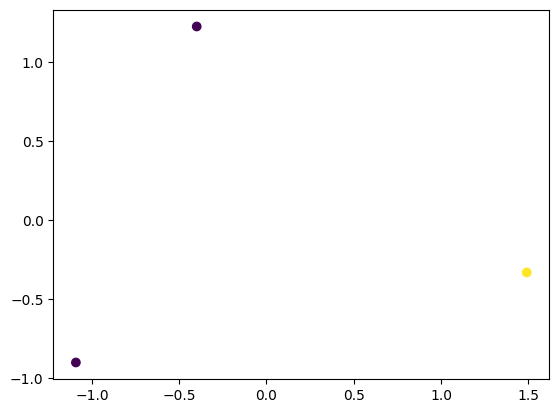

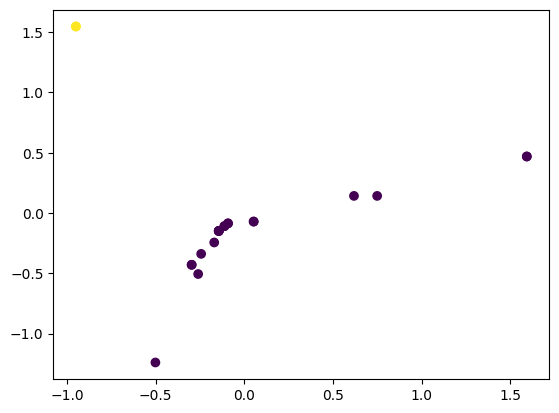

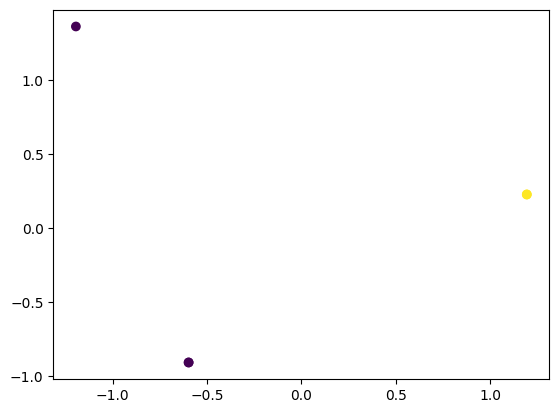

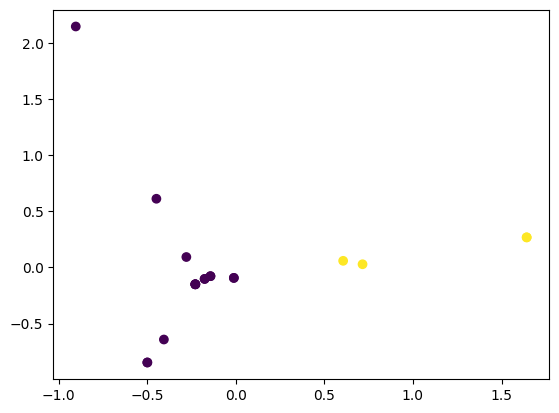

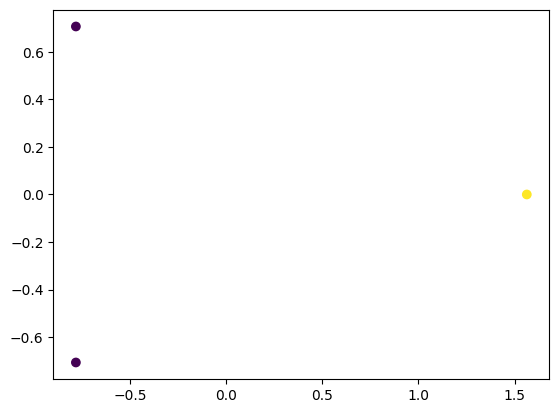

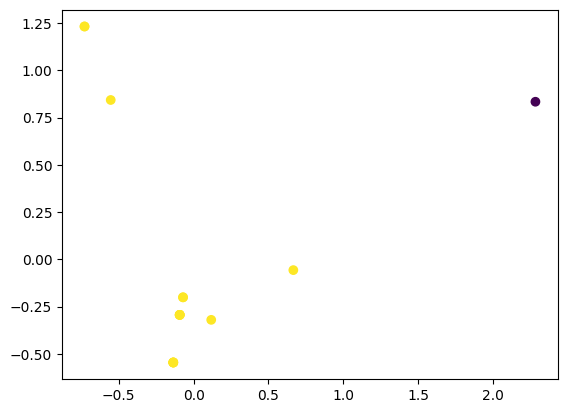

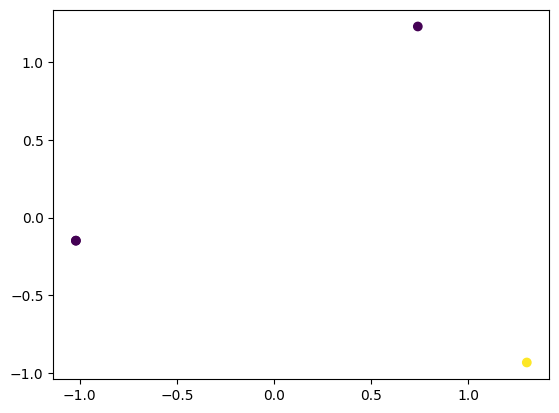

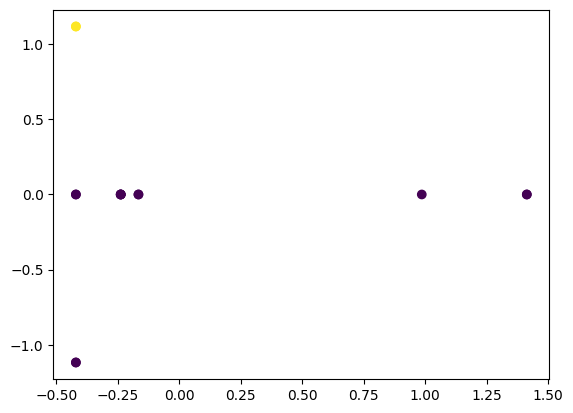

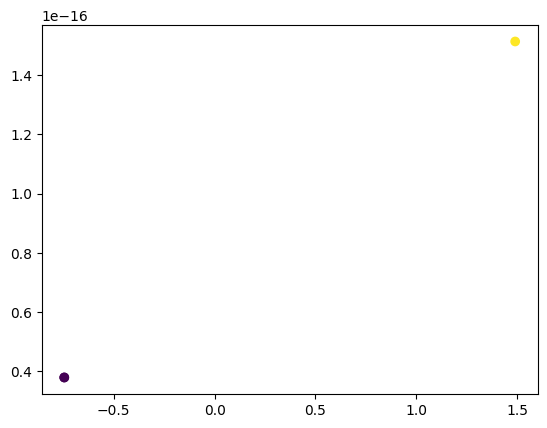

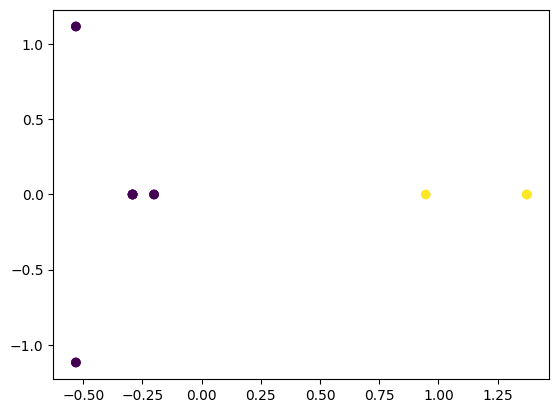

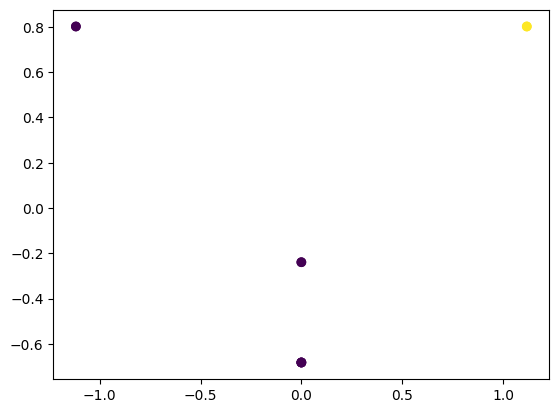

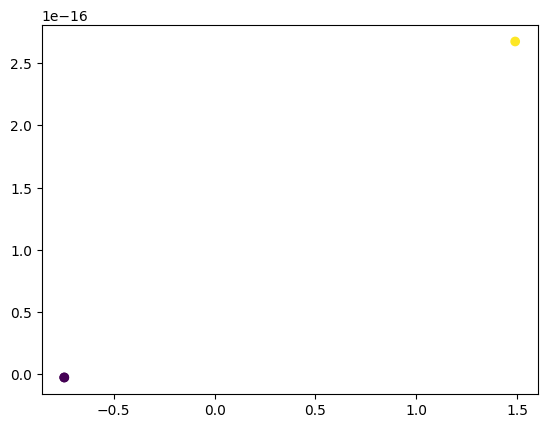

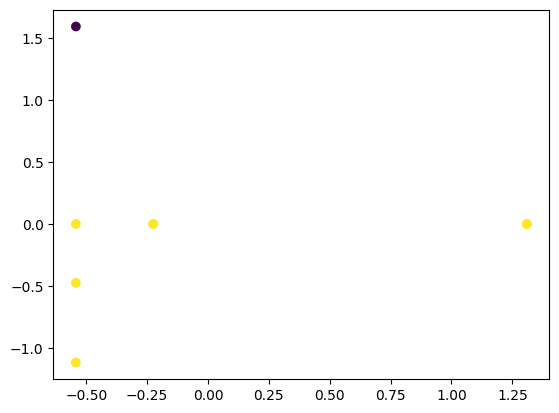

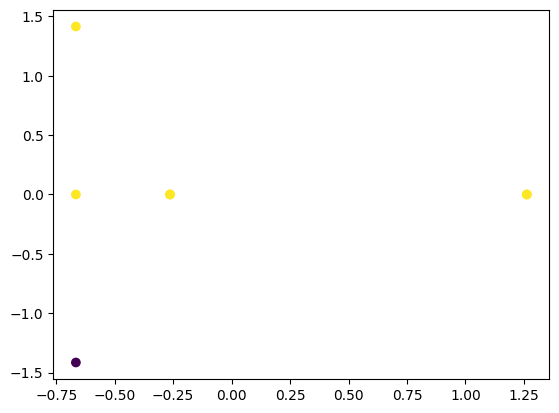

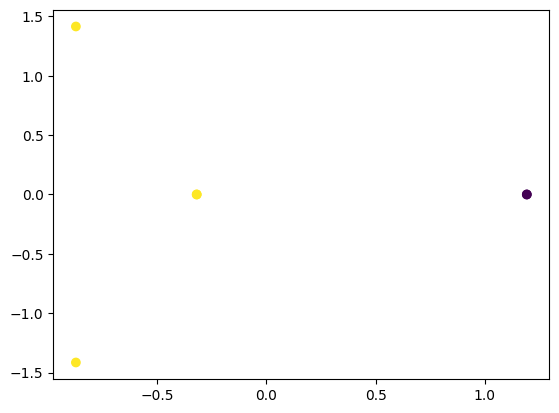

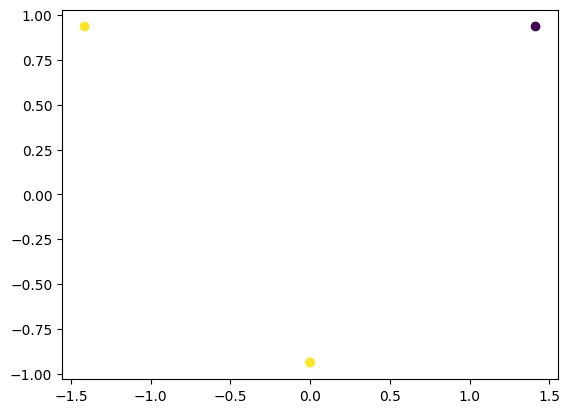

In [67]:
clusters = km(strings)
while max([len(cluster) for cluster in clusters]) > 3:
    for i,cluster in enumerate(clusters):
        clusters[i] = km(cluster)
    clusters = [item for cluster in clusters for item in cluster];

In [68]:
[sorted(cluster) for cluster in clusters]

[['ты нашел их или нет'],
 ['ты любишь яблоки или апельсины', 'ты яблоки любишь или апельсины'],
 ['ты играешь в футбол или регби', 'ты в футбол играешь или в регби'],
 ['чего ты свой нос повсюду суешь'],
 ['он всю ночь стонал от сильной боли'],
 ['я написал влера письмо', 'я написал вчера письмо'],
 ['я тоже завтра пойду в университет'],
 ['я думаю вса время о томе',
  'я полностью с ними согласен',
  'я ему сам позвоню'],
 ['я просто хочу исчезнуть', 'я просто хоку исчезнуть'],
 ['мы сегодня поговорим с томом'],
 ['прибавить пять к десяти легко'],
 ['сколько сейчас времени в париже'],
 ['я живу сейчас в бостоне', 'я сейчас живу в бостоне'],
 ['интерфейс очень интуитивно понятен', 'он очень этого хочет'],
 ['я здесь часто ем'],
 ['здесь есть поблизости банкомат', 'здесь поблизости есть банкомат'],
 ['мы теряем здесь время'],
 ['я покажу вам несколько фотографий', 'я вам покажу несколько фотографий'],
 ['им были нужны деньги', 'им нужны были деньги'],
 ['я завтра им позвоню', 'я им сам

In [70]:
([len(cluster) for cluster in clusters])

[1,
 2,
 2,
 1,
 1,
 2,
 1,
 3,
 2,
 1,
 1,
 1,
 2,
 2,
 1,
 2,
 1,
 2,
 2,
 2,
 1,
 2,
 2,
 2,
 1,
 2,
 2,
 2,
 1,
 1,
 2,
 1,
 2,
 2,
 2,
 2,
 2,
 1,
 2,
 2,
 2,
 2,
 2,
 1,
 1,
 2,
 2,
 1,
 2,
 2,
 1,
 1,
 2,
 2,
 1,
 1,
 1,
 1,
 2,
 1,
 2,
 1,
 2,
 2,
 1,
 2,
 2,
 1,
 3,
 1,
 1,
 2,
 1,
 1,
 2,
 1,
 1,
 1,
 1,
 2,
 1,
 2,
 2,
 2,
 2,
 1,
 2,
 2,
 2,
 1,
 1,
 2,
 1,
 1,
 2,
 1,
 1,
 1,
 2,
 2,
 2,
 2,
 2,
 2,
 1,
 2,
 2,
 2,
 2,
 1,
 2,
 2,
 2,
 2,
 2,
 1,
 2,
 1,
 2,
 2,
 1,
 2,
 1,
 2,
 1,
 2,
 1,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 1,
 1,
 1,
 1,
 2,
 2,
 1,
 2,
 2,
 1,
 1,
 2,
 2,
 2,
 1,
 2,
 2,
 2,
 2,
 2,
 2,
 1,
 2,
 1,
 2,
 2,
 2,
 2,
 1,
 2,
 2,
 1,
 2,
 2,
 1,
 2,
 2,
 1,
 2,
 1,
 2,
 2,
 1,
 1,
 2,
 2,
 2,
 1,
 1,
 1,
 2,
 1,
 2,
 2,
 1,
 1,
 2,
 1,
 2,
 2,
 1,
 2,
 2,
 2,
 2,
 1,
 1,
 2,
 1,
 2,
 1,
 2,
 2,
 1,
 2,
 2,
 1,
 2,
 2,
 1,
 2,
 2,
 2,
 1,
 2,
 2,
 2,
 2,
 2,
 1,
 2,
 2,
 2,
 1,
 1,
 2,
 2,
 2,
 2,
 1,
 2,
 2,
 2,
 2,
 1,
 1,
 1,
 2,
 1,
 1,
 1,
 1,
 2,
 2,
 2,
 1,


In [45]:
test1 = 'какое это имеет отношение к школе'
test2 = 'камое это имеет отношение к школе'

print([list(word) for word in test1.split()])
print()
print([list(word) for word in test2.split()])

[['к', 'а', 'к', 'о', 'е'], ['э', 'т', 'о'], ['и', 'м', 'е', 'е', 'т'], ['о', 'т', 'н', 'о', 'ш', 'е', 'н', 'и', 'е'], ['к'], ['ш', 'к', 'о', 'л', 'е']]

[['к', 'а', 'м', 'о', 'е'], ['э', 'т', 'о'], ['и', 'м', 'е', 'е', 'т'], ['о', 'т', 'н', 'о', 'ш', 'е', 'н', 'и', 'е'], ['к'], ['ш', 'к', 'о', 'л', 'е']]


# 3 вариант

In [246]:
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.decomposition import PCA
from sklearn.cluster import AgglomerativeClustering
import math
from typing import List



def agg(strings):
    if len(set(strings)) <= 2:
        return [strings]
        
    # Векторизация
    Vectorizer = CountVectorizer()
    vector = Vectorizer.fit_transform(strings)
    strings_vectorized = vector.toarray()

    # Уменьшение размерности
    pca_model = PCA(n_components=2).fit(strings_vectorized)
    strings_vectorized_2n = pca_model.transform(strings_vectorized)

    model = AgglomerativeClustering(n_clusters=None,distance_threshold=1.5,compute_distances=True).fit(strings_vectorized_2n)
    clusters = {}
    for i in range(len(model.labels_)):
        if model.labels_[i] not in clusters:
            clusters[model.labels_[i]] = []
        clusters[model.labels_[i]].append(strings[i])

    # plt.scatter(strings_vectorized_2n[:,0],strings_vectorized_2n[:,1],c=model.labels_)
    # plt.show()
    return list(clusters.values())

In [247]:
clusters = agg(strings)

In [248]:
iterations = 10
for iter in range(iterations):
    for i,cluster in enumerate(clusters):
        clusters[i] = agg(cluster)
    clusters = [item for cluster in clusters for item in cluster];

In [249]:
[sorted(cluster) for cluster in clusters]

[['ты нашел их или нет'],
 ['ты в футбол играешь или в регби', 'ты играешь в футбол или регби'],
 ['ты любишь яблоки или апельсины', 'ты яблоки любишь или апельсины'],
 ['чего ты свой нос повсюду суешь'],
 ['почему он так со мной поступает', 'почему она так со мной поступает'],
 ['почему они с нами так поступают', 'почему они так с ним поступают'],
 ['почему она так с ней поступает'],
 ['почему она с ним так поступает', 'почему она так с ним поступает'],
 ['он всю ночь стонал от сильной боли'],
 ['я написал влера письмо', 'я написал вчера письмо'],
 ['я здесь часто ем'],
 ['я полностью с ними согласен'],
 ['я был вынужден уйти', 'я ему сам позвоню'],
 ['прибавить пять к десяти легко'],
 ['мы сегодня поговорим с томом'],
 ['они пили белое сухое вино'],
 ['сколько сейчас времени в париже'],
 ['я живу сейчас в бостоне', 'я сейчас живу в бостоне'],
 ['зачем тому была нужна отвертка', 'она была тогда маленькой девочкой'],
 ['я просто был невнимателен'],
 ['я просто хоку исчезнуть', 'я прост

In [250]:
max([len(cluster) for cluster in clusters])

3

In [251]:
[len(cluster) for cluster in clusters]

[1,
 2,
 2,
 1,
 2,
 2,
 1,
 2,
 1,
 2,
 1,
 1,
 2,
 1,
 1,
 1,
 1,
 2,
 2,
 1,
 2,
 2,
 2,
 2,
 2,
 1,
 2,
 2,
 1,
 2,
 1,
 1,
 1,
 2,
 1,
 1,
 1,
 1,
 3,
 1,
 2,
 1,
 1,
 2,
 2,
 2,
 2,
 2,
 1,
 2,
 2,
 2,
 1,
 1,
 2,
 2,
 2,
 1,
 1,
 2,
 2,
 1,
 1,
 1,
 2,
 2,
 2,
 1,
 1,
 1,
 2,
 1,
 2,
 2,
 2,
 1,
 2,
 1,
 1,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 1,
 2,
 2,
 2,
 1,
 2,
 1,
 2,
 1,
 1,
 2,
 2,
 2,
 2,
 2,
 2,
 1,
 2,
 1,
 2,
 2,
 1,
 2,
 2,
 2,
 1,
 2,
 2,
 2,
 2,
 2,
 1,
 1,
 1,
 2,
 1,
 2,
 2,
 1,
 2,
 2,
 1,
 2,
 1,
 2,
 2,
 1,
 1,
 1,
 1,
 2,
 2,
 1,
 1,
 2,
 2,
 1,
 2,
 1,
 2,
 2,
 2,
 1,
 2,
 2,
 1,
 1,
 1,
 1,
 1,
 1,
 2,
 2,
 1,
 2,
 2,
 1,
 2,
 1,
 2,
 2,
 2,
 2,
 2,
 2,
 1,
 2,
 2,
 1,
 2,
 2,
 2,
 2,
 2,
 1,
 1,
 1,
 2,
 2,
 2,
 2,
 1,
 2,
 2,
 2,
 1,
 2,
 1,
 1,
 2,
 1,
 2,
 1,
 2,
 1,
 1,
 1,
 1,
 1,
 2,
 2,
 1,
 1,
 2,
 1,
 2,
 2,
 2,
 1,
 1,
 2,
 1,
 1,
 2,
 1,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 1,
 2,
 1,
 2,
 2,
 2,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 2,
 2,
 2,
 1,
 1,
 2,
 1,
 1,


In [252]:
save_groups.save_groups(clusters,"../output/solution4-result.json")

In [ ]:
clusters = {}
for i in range(len(model.labels_)):
    if model.labels_[i] not in clusters:
        clusters[model.labels_[i]] = []
    clusters[model.labels_[i]].append(strings[i])

In [7]:
sorted(clusters[2])

['где был том весь день',
 'том - один из лучших моих друзей',
 'том - один из моих лучших друзей',
 'том был мне как отец',
 'том был тогда здесь',
 'том все мне рассказал',
 'том все мне расскатал',
 'том всегда меня смешит',
 'том выпил уже три чашки кофе',
 'том действует мне на нервы',
 'том ест яблоко или банан',
 'том и мэри объявили сегодня о своей пбмолвке',
 'том и мэри объявили сегодня о своей помолвке',
 'том каждое утро читает газету',
 'том меня всегда смешит',
 'том меня сейчас хочет видеть',
 'том мне действует на нервы',
 'том мне сегодня это сказал',
 'том очень мае помог',
 'том очень мне помог',
 'том очень этим гордился',
 'том продал сегоднь три холодильника',
 'том продал сегодня три холодильника',
 'том сегодня будет здесь',
 'том сегодня мне это сказал',
 'том сможет это сделать без нашей помощи',
 'том тебе звонил вчера вечером',
 'том тогда был здесь',
 'том уже выпил три чашки кофе',
 'том уже должен быть дола',
 'том уже должен быть дома',
 'том уже это сде

In [10]:
sorted(clusters[3])

['том больше здесь не работает',
 'том больше мне не доверяет',
 'том больше не может здесь оставаться',
 'том больше не хотел об этом думать',
 'том бы никогда не согласился',
 'том бы никогда не соглхсился',
 'том был не единственным свидетелем',
 'том был просто не готов',
 'том еще нас не видел',
 'том еще ничего мне не сказал',
 'том здесь больше не работает',
 'том нам ничего не дал',
 'том не был занят',
 'том не живет в бостоне',
 'том не знает ничего о семье мэри',
 'том не может жить без мэри',
 'том не может сегодня прийти',
 'том не может сейчас подойти к телефону',
 'том не хотел никуда идти',
 'том не хочет никого видеть',
 'том не хочет сегодня никого видеть',
 'том никогда больше тебя не увидит',
 'том никогда мне не казывал свою фамилию',
 'том никогда мне не называл свою фамилию',
 'том никогда нам ничего не рассказывает',
 'том никогда тебя больше не увидит',
 'том никогда туда больше не вернется',
 'том ничего мне не говорит',
 'том ничего мне не моворит',
 'том нич

In [9]:
sorted([str for str in strings if str.find('том') != -1 and str.find('ничего')!=-1])

['том еще ничего мне не сказал',
 'том нам ничего не дал',
 'том не знает ничего о семье мэри',
 'том никогда нам ничего не рассказывает',
 'том ничего мне не говорит',
 'том ничего мне не моворит',
 'том ничего нам не дал',
 'том ничего нам не платит',
 'том ничего не знает о семье мэри',
 'том сказал что ничего не хочет есть',
 'я ничего не хочу об этом знать']

### Решение основано на поэтапном отборе групп
Применяются следующие алгоритмы:
* Растояние Карловского
* Сравнение множеств слов
* Расстояние Хэмминга
* Косинусное сходство с векторизацией TF-IDF
* Сходство Джаро-Винклера
* Сравнение наборов местоимений


In [5]:
pd.options.mode.chained_assignment = None # Убираем лишние предупреждения
df['used'] = [False] * len(df)

# Функция фильтрации на основе алгоритма верификации рерайтов (function) и заданного ограничения (threshold) 
# c возможностью проверки наборов местоимений (check_pronoun) 
def filter(groups,function,threshold,check_pronoun=True):
    for i in tqdm(range(len(df))):
        if df['used'][i]:  # Проверка метки использования строки
            continue
        groups.append([])
        groups[-1].append(df['text'][i])
        df['used'][i] = True
        
        for j in range(i+1,len(df)):
            if df['used'][j]: # Проверка метки использования строки
                continue
            if check_pronoun:
                if(function(df['text_preprocess'][i],df['text_preprocess'][j],threshold) and pronouns.check_pronoun_correspondence(df['text_preprocess'][i],df['text_preprocess'][j])):
                    groups[-1].append(df['text'][j])
                    df['used'][j] = True
            else:
                if(function(df['text_preprocess'][i],df['text_preprocess'][j],threshold)):
                    groups[-1].append(df['text'][j])
                    df['used'][j] = True
        if len(groups[-1]) == 1: # Если строка не имеет рерайта, то группа не формируется
            df['used'][i] = False 
            groups = groups[:-1]
    return groups

groups = []
# Фильтрация на основе алгоритмов верификации рерайтов
groups = filter(groups,karlovskiy_distance.is_rewrite_karlovskiy_distance,0.89,check_pronoun=True)
groups = filter(groups,word_set.is_rewrite_word_set,threshold=0.99,check_pronoun=False)
groups = filter(groups,hamming_distance_custom.is_rewrite_hamming_distance_custom,threshold=0.9,check_pronoun=False)
groups = filter(groups,cosine_tfidf.is_rewrite_cosine_tfidf,0.7,check_pronoun=True)
groups = filter(groups,jaro_winkler.is_rewrite_jaro_winkler,0.9,check_pronoun=True)

# Добавляем уникальные строки (не имеющие рерайт)
groups = groups + [[str] for str in list(df[df['used']==False]['text'])]

df = df.drop('used',axis=1)

  0%|          | 0/412 [00:00<?, ?it/s]

  0%|          | 0/412 [00:00<?, ?it/s]

  0%|          | 0/412 [00:00<?, ?it/s]

  0%|          | 0/412 [00:00<?, ?it/s]

  0%|          | 0/412 [00:00<?, ?it/s]

### Количество найденных групп

In [6]:
len(groups)

277

### Все найденные группы

In [7]:
groups

[['Никто туда больше не ходит.', 'Никто больше туда не ходит.'],
 ['У него с собой не было тогда денег.',
  'У него тогда не было с собой денег.'],
 ['Я больше не хочу с тобой играть.', 'Я не хочу с тобой больше играть.'],
 ['Что сделал Том с деньгами?', 'Что сделёл Том с деньгами?'],
 ['Том меня сейчас хочет видеть?', 'Том хочет меня сейчас видеть?'],
 ['Я его больше не увижу.', 'Я больше его не увижу.'],
 ['Том и Мэри объявили сегодня о своей пбмолвке.',
  'Том и Мэри объявили сегодня о своей помолвке.'],
 ['Я не могу больше ждать.', 'Я больше не могу ждать.'],
 ['Мост очень длинный и высокий.', 'Мост очень длинный и очень высокий.'],
 ['Пусть свиньи это едят.', 'Пусть это свиньи едят.'],
 ['Ты хотел мне рассказать о свободе?', 'Ты хотел рассказать мне о свободе?'],
 ['Что пел Джон на сцене?', 'Что Джон пел на сцене?'],
 ['Я написал влера письмо.', 'Я написал вчера письмо.'],
 ['Мы не были готовы.', 'Мы были не готовы.'],
 ['Они их только что нашли.', 'Они только что их нашли.'],
 ['

### Строки, которые имеют более 1 рерайта

In [8]:
groups3 = [group for group in groups if len(group) > 2]

In [9]:
len(groups3)

1

In [10]:
groups3

[['Том не хочет никого видеть.',
  'Том не хочет сегодня никого видеть.',
  'Том сегодня не хочет никого видеть.']]

### Строки, которые имеют ровно 1 рерайт

In [11]:
groups2 = [group for group in groups if len(group) == 2]

In [12]:
len(groups2)

133

In [13]:
groups2

[['Никто туда больше не ходит.', 'Никто больше туда не ходит.'],
 ['У него с собой не было тогда денег.',
  'У него тогда не было с собой денег.'],
 ['Я больше не хочу с тобой играть.', 'Я не хочу с тобой больше играть.'],
 ['Что сделал Том с деньгами?', 'Что сделёл Том с деньгами?'],
 ['Том меня сейчас хочет видеть?', 'Том хочет меня сейчас видеть?'],
 ['Я его больше не увижу.', 'Я больше его не увижу.'],
 ['Том и Мэри объявили сегодня о своей пбмолвке.',
  'Том и Мэри объявили сегодня о своей помолвке.'],
 ['Я не могу больше ждать.', 'Я больше не могу ждать.'],
 ['Мост очень длинный и высокий.', 'Мост очень длинный и очень высокий.'],
 ['Пусть свиньи это едят.', 'Пусть это свиньи едят.'],
 ['Ты хотел мне рассказать о свободе?', 'Ты хотел рассказать мне о свободе?'],
 ['Что пел Джон на сцене?', 'Что Джон пел на сцене?'],
 ['Я написал влера письмо.', 'Я написал вчера письмо.'],
 ['Мы не были готовы.', 'Мы были не готовы.'],
 ['Они их только что нашли.', 'Они только что их нашли.'],
 ['

### Строки, которые не имеют рерайта

In [14]:
groups1 = [group for group in groups if len(group) == 1]

In [15]:
len(groups1)

143

In [16]:
groups1

[['Ты нашёл их или нет?'],
 ['Почему она так со мной поступает?'],
 ['Почему они с нами так поступают?'],
 ['Он всю ночь стонал от сильной боли.'],
 ['Тому было тогда всего тринадцать лет.'],
 ['Он даже меня не замечает.'],
 ['Тебе это всё нравится?'],
 ['Почему она так с ней поступает?'],
 ['Я хотел бы учиться в Бостоне.'],
 ['Том этим сейчас занимается.'],
 ['Том был просто не готов.'],
 ['Тому это тоже не нравится.'],
 ['Сколько сейчас времени в Париже?'],
 ['Тому было больше не к кому обратиться.'],
 ['Он сказал, что вчера был дома.'],
 ['Они никогда меня не слушают.'],
 ['Я поймал сегодня три рыбы.'],
 ['Я хочу что-нибудь сделать для Тома.'],
 ['Я сделал всё правильно?'],
 ['Я тоже завтра пойду в университет.'],
 ['Мне никогда не нужно было столько денег.'],
 ['Том не может жить без Мэри.'],
 ['Почему они так с ним поступают?'],
 ['Что могло с ними случиться?'],
 ['Мы будем делать всё по-своему.'],
 ['Где был Том весь день?'],
 ['Я здесь часто ем.'],
 ['Я всё ей рассказываю.'],
 [

### Сохранение результата

In [17]:
save_groups.save_groups(groups,"../output/solution1-result.json")